In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import time
from time import mktime
from matplotlib import pyplot as plt
import seaborn as sns
import patsy
from patsy import dmatrices
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import folium
from pandas import *
from folium.map import Icon, Marker, Popup
import pickle

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [87]:
NY_merged_samp = pd.read_pickle('../../datasets/NY_merged_samp.pkl')

In [88]:
## The Transportation Division of the New York City Department of City Planning (NYCDCP) has performed annual 
## bike counts in Manhattan since 1999. The counts have been conducted along designated bicycle routes at 10 
## on-street and 5 off-street locations during the fall season. These locations have remained generally consistent. 
## The data collected includes cyclist/user volumes, helmet usage, use of bike lane, gender, etc. The bike counts 
## data can offer insights into the overall trends in user demographics and travel patterns over time.

bike_count = pd.read_csv('../../../Desktop/datasets/NYC_bike_count.csv', parse_dates=True)
bike_count.dropna(inplace=True)

In [151]:
## creating a function that separates my data into different segments for time series analysis

def segment_func(bike_df, start_date, end_date):
    segment_mask = (bike_df['DATE'] >= start_date) & (bike_df['DATE'] <= end_date)
    bike_segment = bike_df[segment_mask]
    return bike_segment

## creating a borough column to create another feature for my model

def borough(col):
    borough_cat = []
    for i in col:
        if i == 'BROOKLYN':
            borough_cat.append(1)
        elif i == 'MANHATTAN':
            borough_cat.append(2)
        elif i == 'QUEENS':
            borough_cat.append(3)
        elif i == 'BRONX':
            borough_cat.append(4)
        elif i == 'STATEN ISLAND':
            borough_cat.append(5)
        else:
            borough_cat.append(0)
    return borough_cat

## assigning a month column to create another feature for my model

def month_extract(col):
    MONTH = []
    for i in col:
        MONTH.append(i.month)
    return MONTH

def month_name(col):
    month_name = []
    for i in col:
        if i == 1:
            month_name.append('Jan')
        elif i == 2:
            month_name.append('Feb')
        elif i == 3:
            month_name.append('Mar')
        elif i == 4:
            month_name.append('Apr')
        elif i == 5:
            month_name.append('May')
        elif i == 6:
            month_name.append('Jun')
        elif i == 7:
            month_name.append('Jul')
        elif i == 8:
            month_name.append('Aug')
        elif i == 9:
            month_name.append('Sep')
        elif i == 10:
            month_name.append('Oct')
        elif i == 11:
            month_name.append('Nov')
        elif i == 12:
            month_name.append('Dec')
        else:
            month_name.append('NA')
    return month_name

## writing a function to extract the hour of the day from the datetime objects ('DATE' column) so that I can plot each 
## segment's volume of injury/death per each hour and see what time of day is most dangerous.

def hour_extract(col):
    HOUR = []
    for i in col:
        HOUR.append(i.hour)
    return HOUR

## extracting the year from the date column
def year(col):
    year = []
    for i in col:
        year.append(i.year)
    return year

## making a function that will convert the Army time hour to a standard hour of the day (example: 20 --> 8pm)

def time_segment(col):
    time_segment = []
    for i in col:
        if (i >= 0) & (i <= 6):
            time_segment.append('early_morning')
        elif (i > 6) & (i <= 12):
            time_segment.append('mid-morning')
        elif (i > 12) & (i <= 15):
            time_segment.append('afternoon')
        elif (i > 15) & (i <= 19):
            time_segment.append('evening')
        elif (i > 19) & (i<=24):
            time_segment.append('late-night')
        else:
            time_segment.append('NA')
    return time_segment
        
## making a function that creates a list containing a '1' if there was a cyclist injured/killed and a '0' if there were
## no cyclists injured/killed

def binary(col):
    CYCLISTS_INJURED = []
    for i in col:
        if i > 0:
            CYCLISTS_INJURED.append(1)
        else:
            CYCLISTS_INJURED.append(0)
    return CYCLISTS_INJURED

def weather(col):
    rain = []
    for i in col:
        if i > 0:
            rain.append(1)
        else:
            rain.append(0)
    return rain

## building a function that separates the amount of precipitation in NYC into 6 varying buckets of intensity (0:5)

def precip(col):
    precip_cat = []
    for i in col:
        if (i > 0) & (i <= 1.00):
            precip_cat.append(1)
        elif (i > 1.00) & (i <= 2.00):
            precip_cat.append(2)
        elif (i > 2.00) & (i <= 3.00):
            precip_cat.append(3)
        elif (i > 3.00) & (i <= 4.00):
            precip_cat.append(4)
        elif (i > 4.00) & (i <= 5.00):
            precip_cat.append(5)
        else:
            precip_cat.append(0)
    return precip_cat


## building a function that separates the mean temperature/dewpoints of each day in NYC into 20+ buckets between 
## the range 0 and 100

def temp(col):
    temp_cat = []
    for i in col:
        if (i > -20) & (i <= 0):
            temp_cat.append(1)
        elif (i > 0) & (i <= 20):
            temp_cat.append(2)
        elif (i > 20) & (i <= 40):
            temp_cat.append(3)
        elif (i > 40) & (i <= 60):
            temp_cat.append(4)
        elif (i > 60) & (i <= 80):
            temp_cat.append(5)
        elif (i > 80) & (i <= 100):
            temp_cat.append(6)   
        else:
            temp_cat.append('NA')
    return temp_cat
            
            
def wind(col):
    wind_cat = []
    for i in col:
        if (i >= 0) & (i <= 5):
            wind_cat.append(1)
        elif (i > 5) & (i <= 10):
            wind_cat.append(2)
        elif (i > 10) & (i <= 15):
            wind_cat.append(3)
        else:
            wind_cat.append(4)
    return wind_cat

def pop(col):
    NEW_TIME = []
    for i in col:
        NEW_TIME.append(i[:-3])
    return NEW_TIME

def weekday(col):
    day_of_week = []
    for i in col:
        day_of_week.append(i.weekday())
    return day_of_week

In [90]:
## renaming the columns in the sample merged dataset

NY_merged_samp.rename(columns={'NUMBER_OF_CYCLIST_INJURED':'injuries',
                               'NUMBER_OF_CYCLIST_KILLED':'deaths',
                              'CONTRIBUTING_FACTOR_VEHICLE_1':'vehicle_1',
                               'Max_TemperatureF':'max_temp',
                               'Mean_TemperatureF':'mean_temp',
                               'Min_TemperatureF':'min_temp',
                               'Max_Dew_PointF':'max_dew',
                               'MeanDew_PointF':'mean_dew',
                               'Min_DewpointF':'min_dew',
                               'Max_Humidity':'max_humid',
                               '_Mean_Humidity':'mean_humid',
                               '_Min_Humidity':'min_humid',
                               '_Max_VisibilityMiles':'max_visible',
                               '_Mean_VisibilityMiles':'mean_visible', 
                               '_Min_VisibilityMiles':'min_visible',
                               '_Max_Wind_SpeedMPH':'max_wind',
                               '_Mean_Wind_SpeedMPH':'mean_wind',
                               '_Max_Gust_SpeedMPH':'max_gust',
                               'PrecipitationIn':'precip', 
                               '_CloudCover':'clouds'
                              },inplace=True)


NY_merged_samp.precip.replace('T', '0', inplace=True)
NY_merged_samp.precip = NY_merged_samp.precip.astype(float)

In [152]:
## passing columns through my functions to create the features to include in my model

NY_merged_samp['borough_cat'] = borough(NY_merged_samp['BOROUGH'])
NY_merged_samp['precip_scale'] = precip(NY_merged_samp['precip'])
NY_merged_samp['month'] = month_extract(NY_merged_samp['DATE'])
NY_merged_samp['injuries_binary'] = binary(NY_merged_samp['injuries'])
NY_merged_samp['temp_cat'] = temp(NY_merged_samp['mean_temp'])
NY_merged_samp['dew_cat'] = temp(NY_merged_samp['mean_dew'])
NY_merged_samp['humid_cat'] = temp(NY_merged_samp['mean_humid'])
NY_merged_samp['time_segment'] = time_segment(NY_merged_samp['TIME'])
NY_merged_samp['day_of_week'] = weekday(NY_merged_samp['DATE'])
NY_merged_samp['year'] = year(NY_merged_samp['DATE'])
NY_merged_samp['month_name'] = month_name(NY_merged_samp['month'])

In [92]:
## grouping the cyclist count dataset by year

count_group = bike_count.groupby(['Year'])[['MaleCyc_Total', 'FemaleCyc_Total']].sum().reset_index()
count_group.columns = [['year', 'm_cyclists', 'f_cyclists']]

# # ## creating a total column that is the sum of both male and female riders 
count_group['total_cyclists'] = count_group['m_cyclists'] + count_group['f_cyclists']

# # ## assigning the year column to be the index of the df
count_group.index = count_group['year']

# # ## deleting the year column since it's already the index
del count_group['year']

In [93]:
count_group.reset_index()

,year,m_cyclists,f_cyclists,total_cyclists
0,2005,6178,982,7160
1,2006,5974,993,6967
2,2007,6437,1153,7590
3,2008,7880,1602,9482
4,2009,8205,1769,9974
5,2010,8609,1998,10607
6,2011,8133,1841,9974
7,2012,9069,2130,11199
8,2013,10756,3004,13760
9,2014,10407,2751,13158


In [94]:
import matplotlib.patches as patches

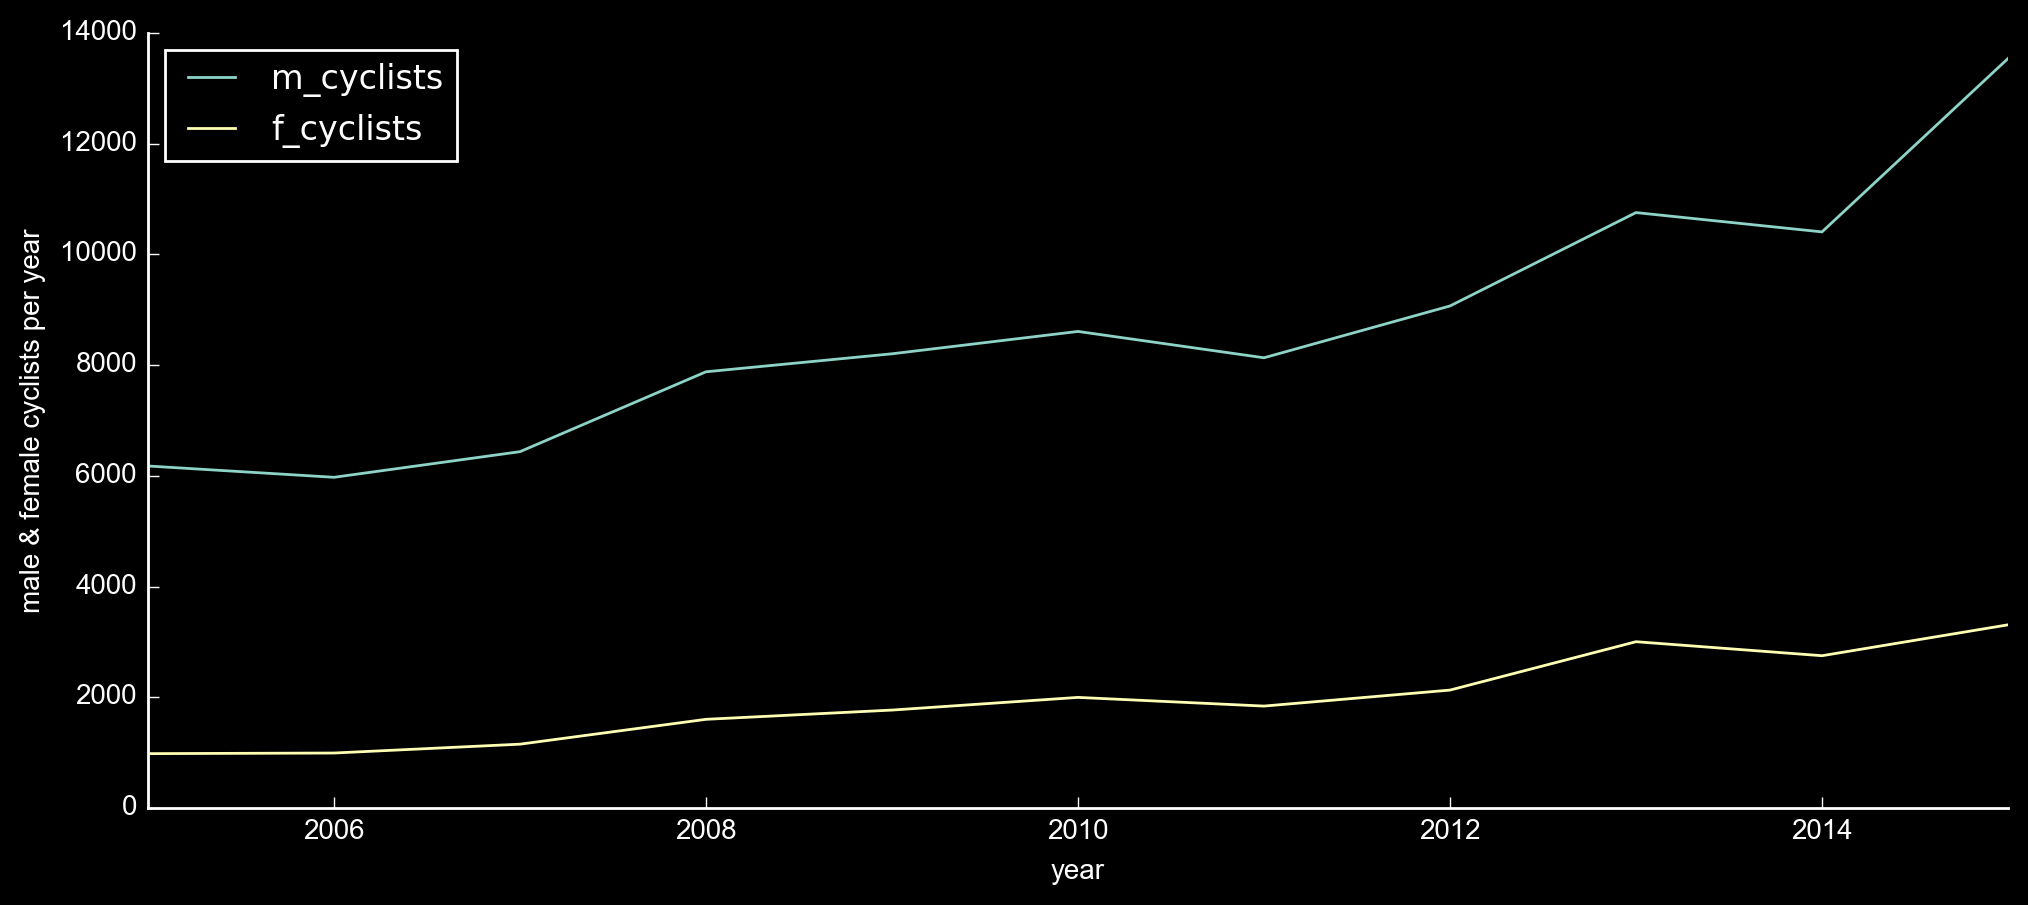

In [96]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))
count_group.reset_index().groupby(['year'])['m_cyclists'].sum().plot()
count_group.reset_index().groupby(['year'])['f_cyclists'].sum().plot()

ax.legend(loc='upper left')
ax.set_ylabel('male & female cyclists per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

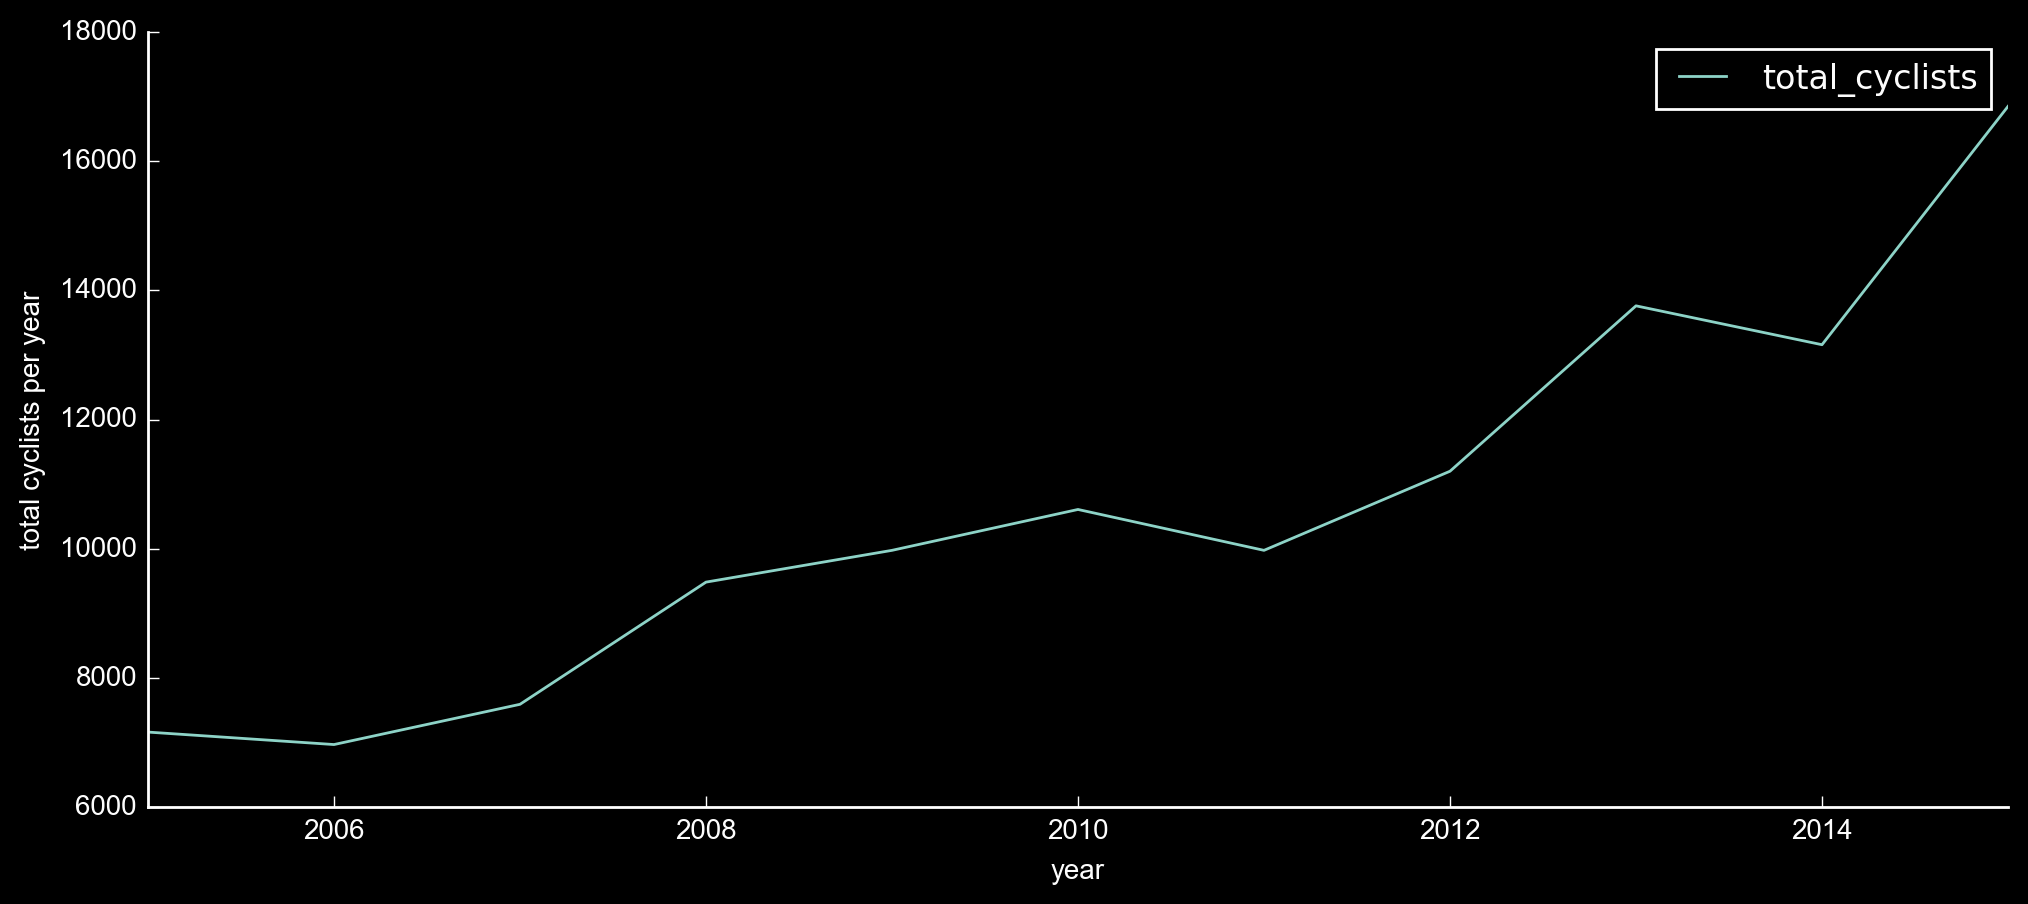

In [97]:
## plotting the rolling number of cyclists across several years for both men, women, and the combined numbers of both groups
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))
count_group.reset_index().groupby(['year'])['total_cyclists'].sum().plot()
ax.legend(loc='upper right')
ax.set_ylabel('total cyclists per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [30]:
## masking my dataset so that the only data that shows is instances in which cycling accidents have occurred and where
## the borough is not '0'

NY_mask = NY_merged_samp[NY_merged_samp['BOROUGH'] != 0]
NY_mask = NY_mask[NY_mask['injuries'] != 0]

In [76]:
NY_mask_ = NY_merged_samp[NY_merged_samp['injuries'] == 0]

In [ ]:
## create a threshold for variable(s) that could potentially impact target, once crossed

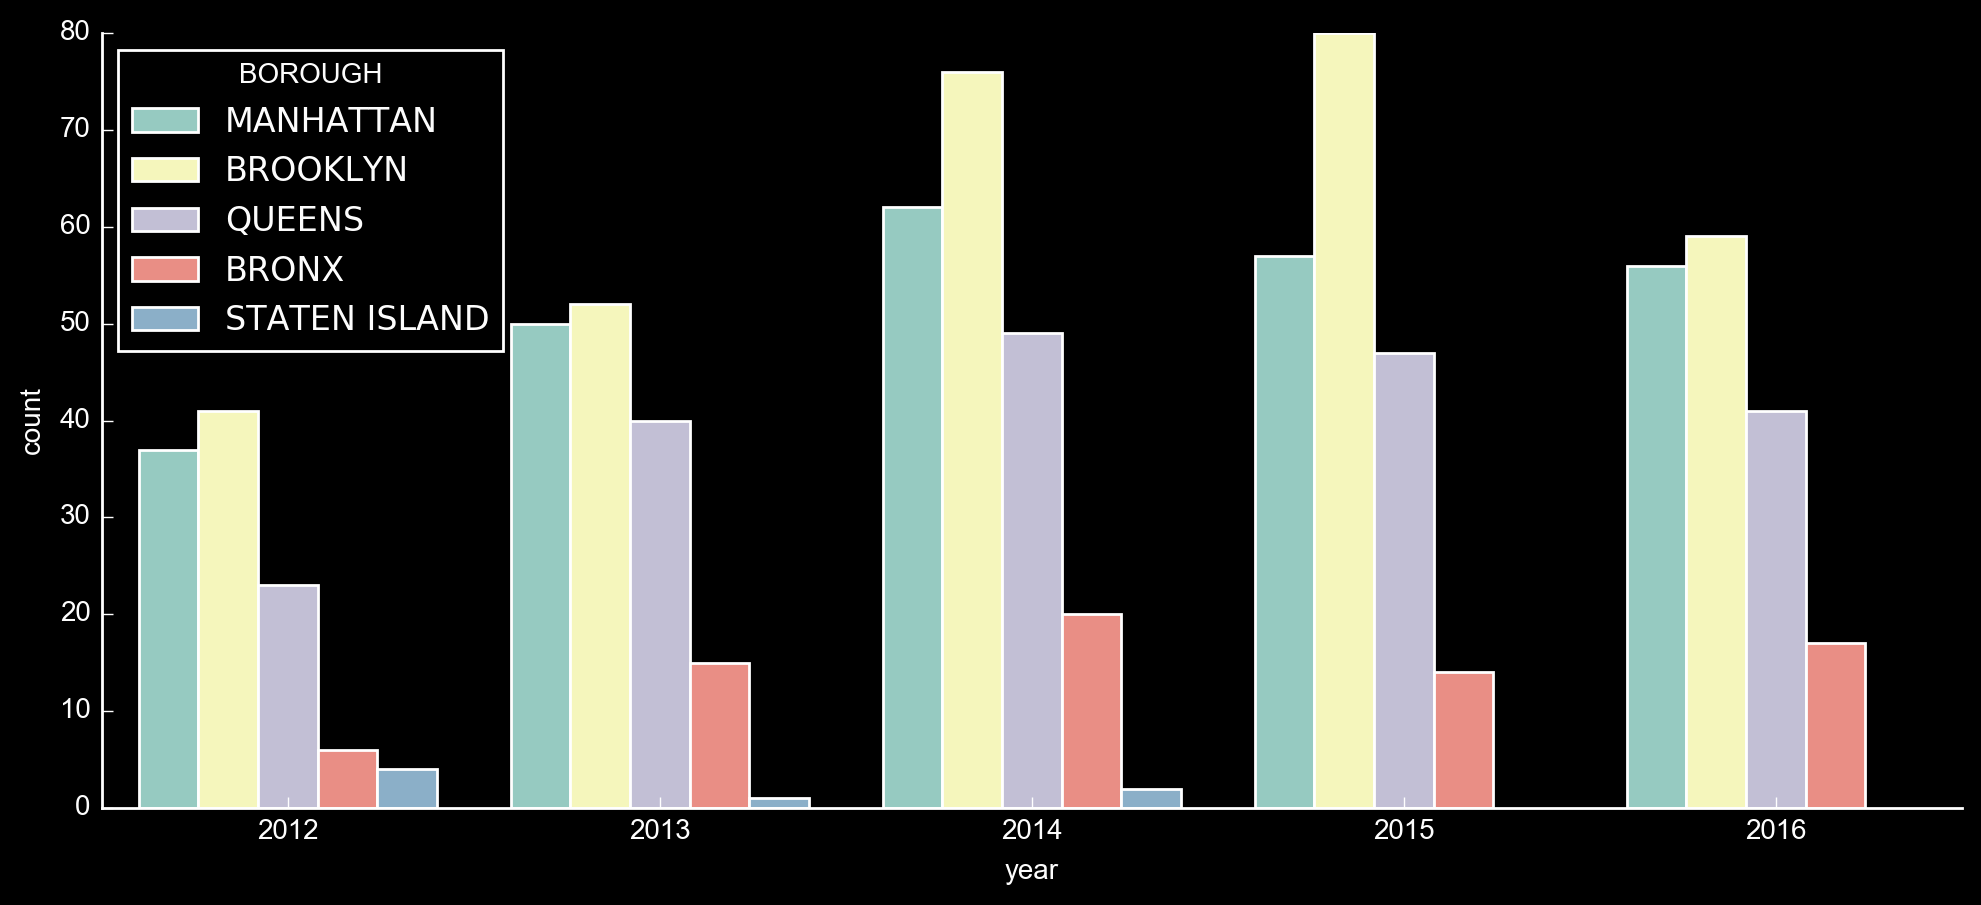

In [98]:
## plotting the number of cycling injuries by for each borough over the span of five years

fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('dark_background')
sns.countplot(x='year', data=NY_mask, hue='BOROUGH')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [124]:
NY_mask.columns

Index([u'DATE', u'TIME', u'BOROUGH', u'ZIP_CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON_STREET_NAME', u'CROSS_STREET_NAME',
       u'OFF_STREET_NAME', u'NUMBER_OF_PERSONS_INJURED',
       u'NUMBER_OF_PERSONS_KILLED', u'NUMBER_OF_PEDESTRIANS_INJURED',
       u'NUMBER_OF_PEDESTRIANS_KILLED', u'injuries', u'deaths',
       u'NUMBER_OF_MOTORIST_INJURED', u'NUMBER_OF_MOTORIST_KILLED',
       u'vehicle_1', u'CONTRIBUTING_FACTOR_VEHICLE_2',
       u'CONTRIBUTING_FACTOR_VEHICLE_3', u'CONTRIBUTING_FACTOR_VEHICLE_4',
       u'CONTRIBUTING_FACTOR_VEHICLE_5', u'UNIQUE_KEY', u'VEHICLE_TYPE_CODE_1',
       u'VEHICLE_TYPE_CODE_2', u'VEHICLE_TYPE_CODE_3', u'VEHICLE_TYPE_CODE_4',
       u'VEHICLE_TYPE_CODE_5', u'max_temp', u'mean_temp', u'min_temp',
       u'max_dew', u'mean_dew', u'min_dew', u'max_humid', u'mean_humid',
       u'min_humid', u'_Max_Sea_Level_PressureIn',
       u'_Mean_Sea_Level_PressureIn', u'_Min_Sea_Level_PressureIn',
       u'max_visible', u'mean_visible', u'min_visib

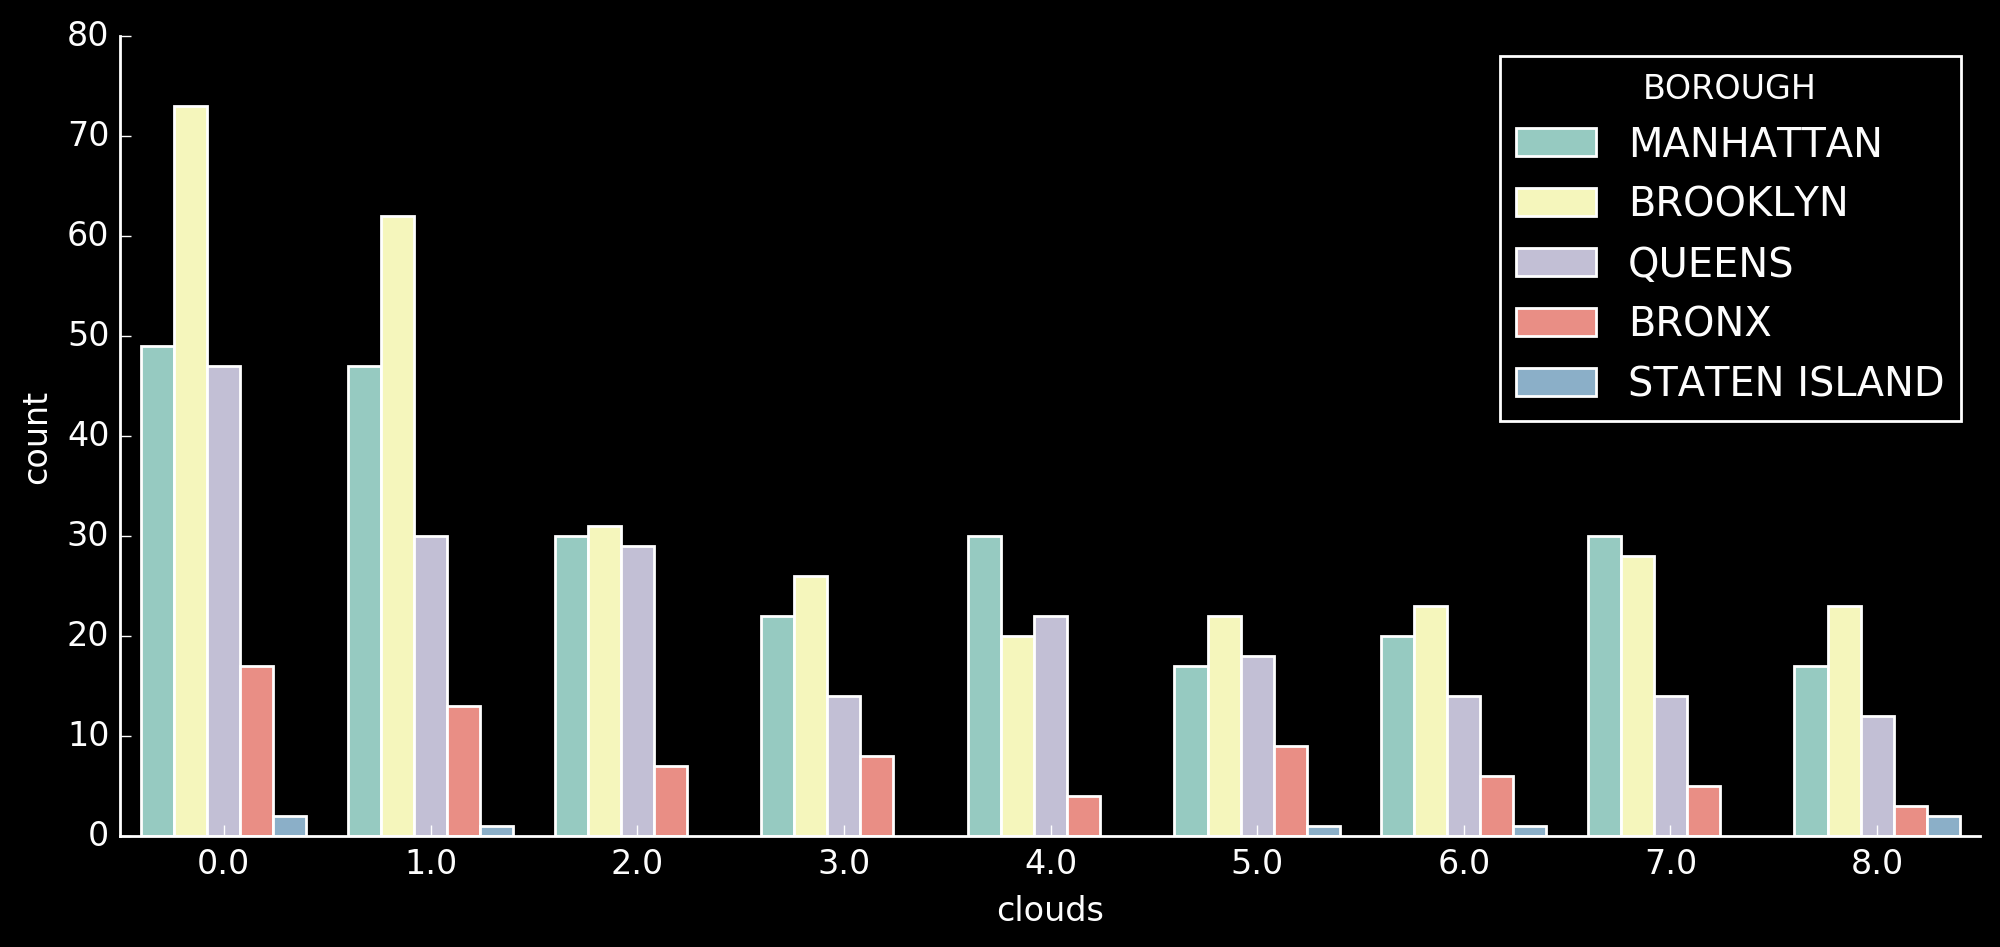

In [127]:
## plotting the number of cloud coverage by borough

fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('dark_background')
sns.countplot(x='clouds', data=NY_mask, hue='BOROUGH')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

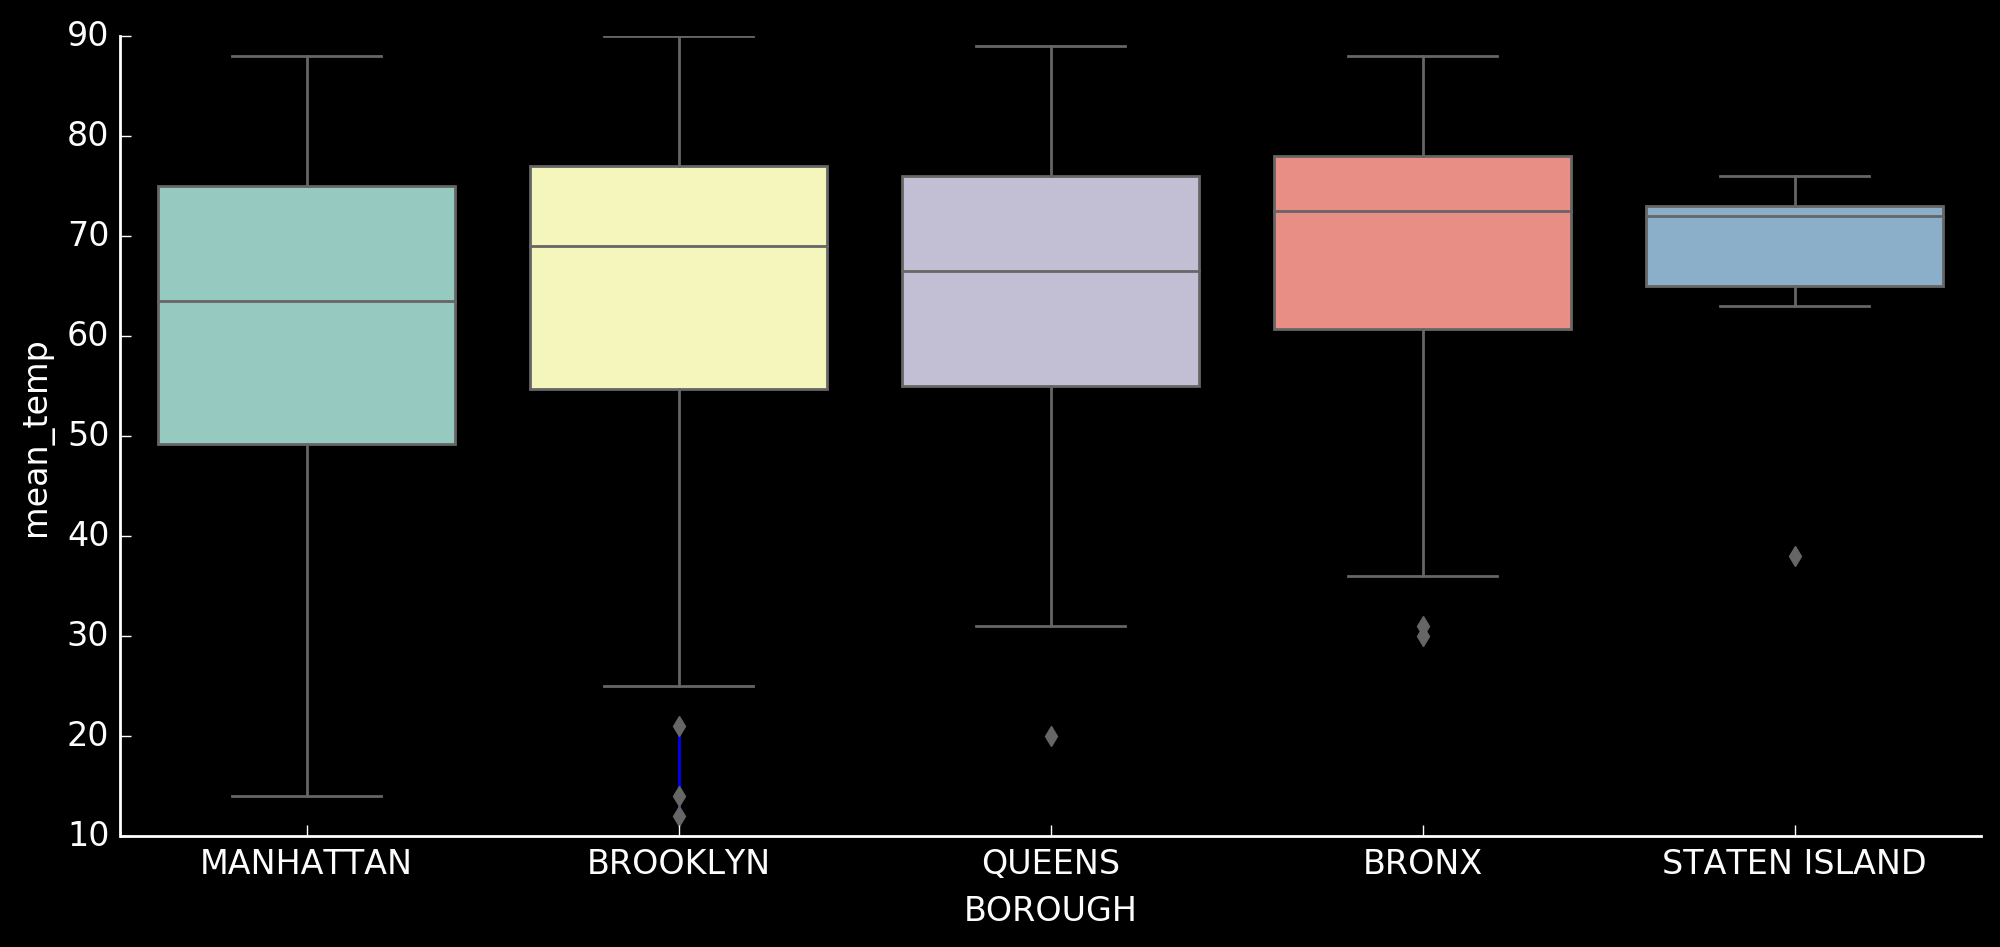

In [138]:
## plotting the amount of precipitation by borough, using the scale

fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('dark_background')
sns.boxplot(x='BOROUGH',y='mean_temp',data=NY_mask)
ax.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

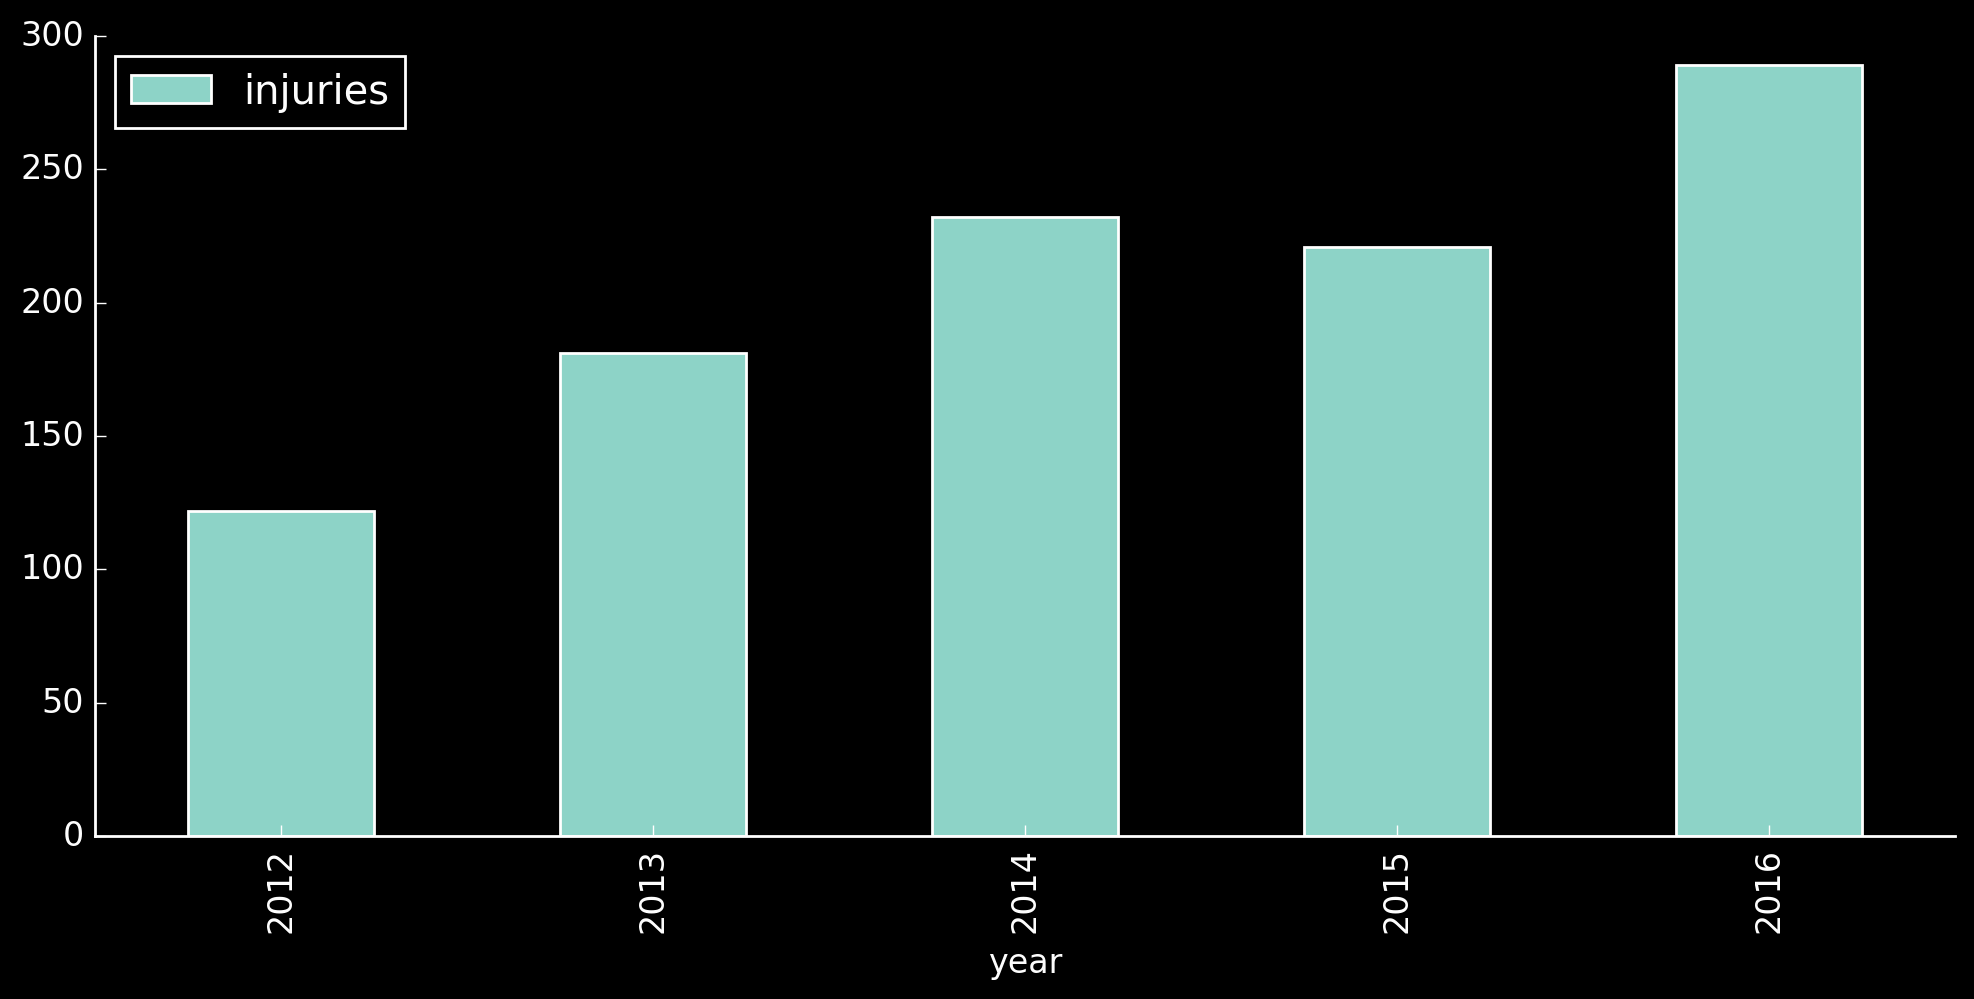

In [128]:
fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('dark_background')

NY_merged_samp.groupby(['year'])['injuries'].sum().plot('bar')
ax.legend(loc = 'upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [46]:
## creating the year column in the df
# NY_merged_samp['year'] = year(NY_merged_samp['DATE'])
## creating a df of the overall grouped by year
NY_groupby = NY_merged_samp.groupby(['year'])['injuries'].sum()
NY_groupby = pd.DataFrame(NY_groupby)
## adding the column of total riders so I can compare the amount of injuries
NY_groupby['m_cyclists'] = count_group['m_cyclists']
NY_groupby['f_cyclists'] = count_group['f_cyclists']
NY_groupby['total_cyclists'] = count_group['total_cyclists']
## renaming the injury column
NY_groupby.columns = [['cyclist_injured', 'm_cyclists', 'f_cyclists', 'total_cyclist']]
NY_groupby.dropna(inplace=True)
NY_groupby.reset_index(inplace=True)

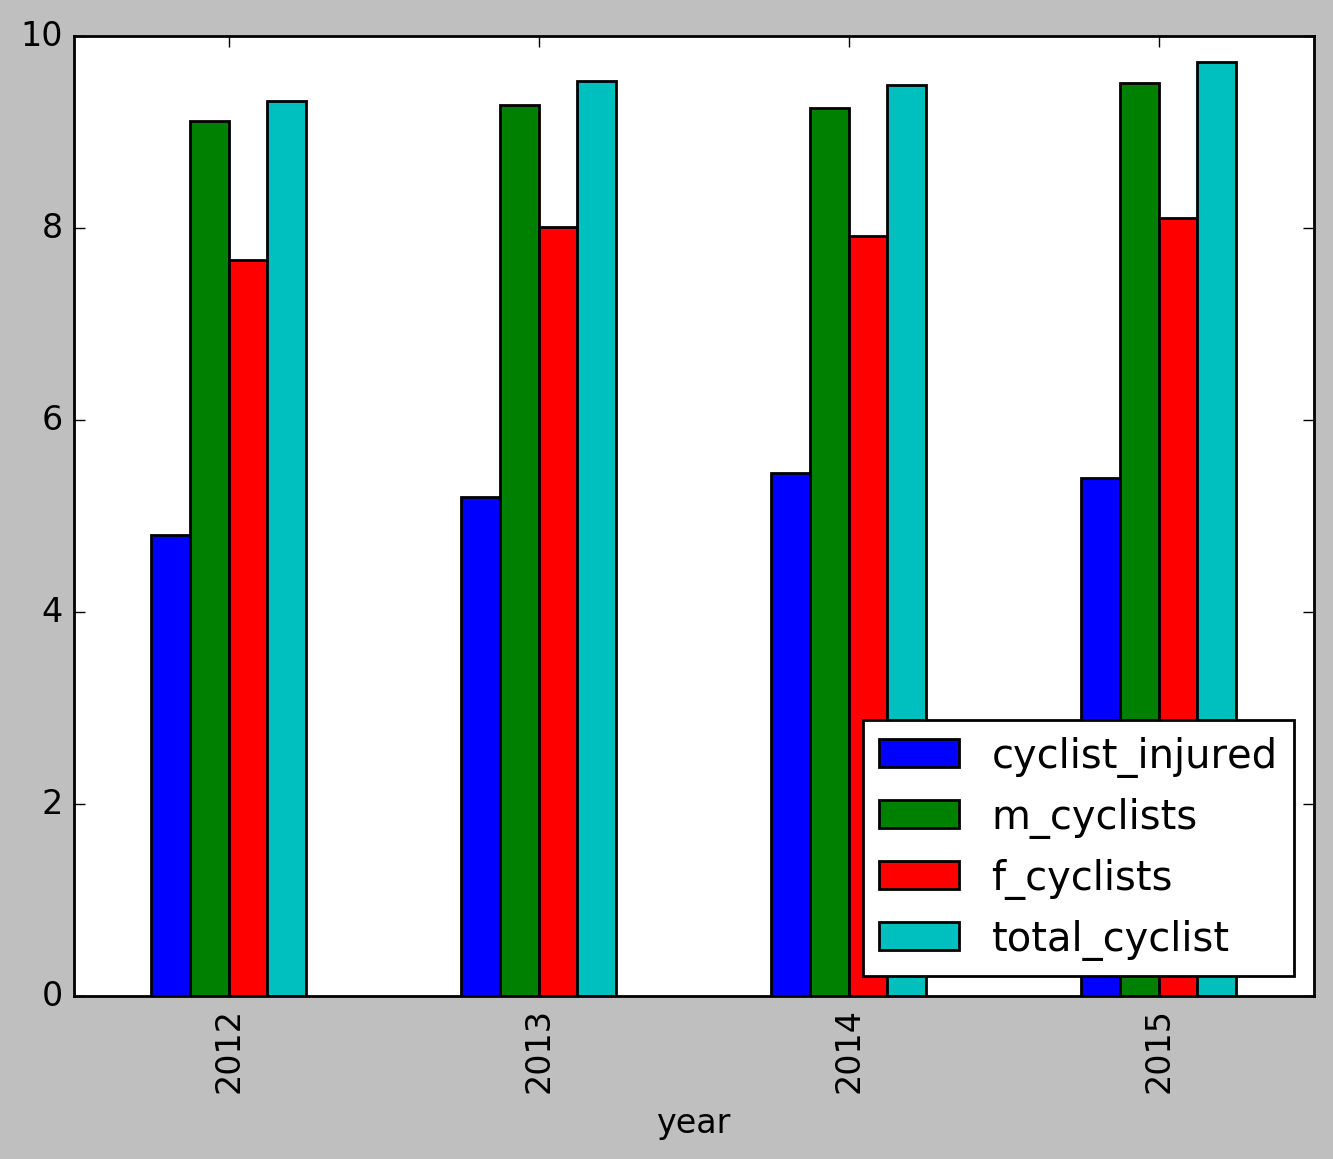

In [100]:
## creating a logged version of the NY_groupby dataframe to handle the outliers

NY_log = np.log(NY_groupby[['cyclist_injured','m_cyclists','f_cyclists','total_cyclist']])
NY_log.index = NY_groupby['year']

plt.style.use('classic')
NY_log.plot(kind='bar')
plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

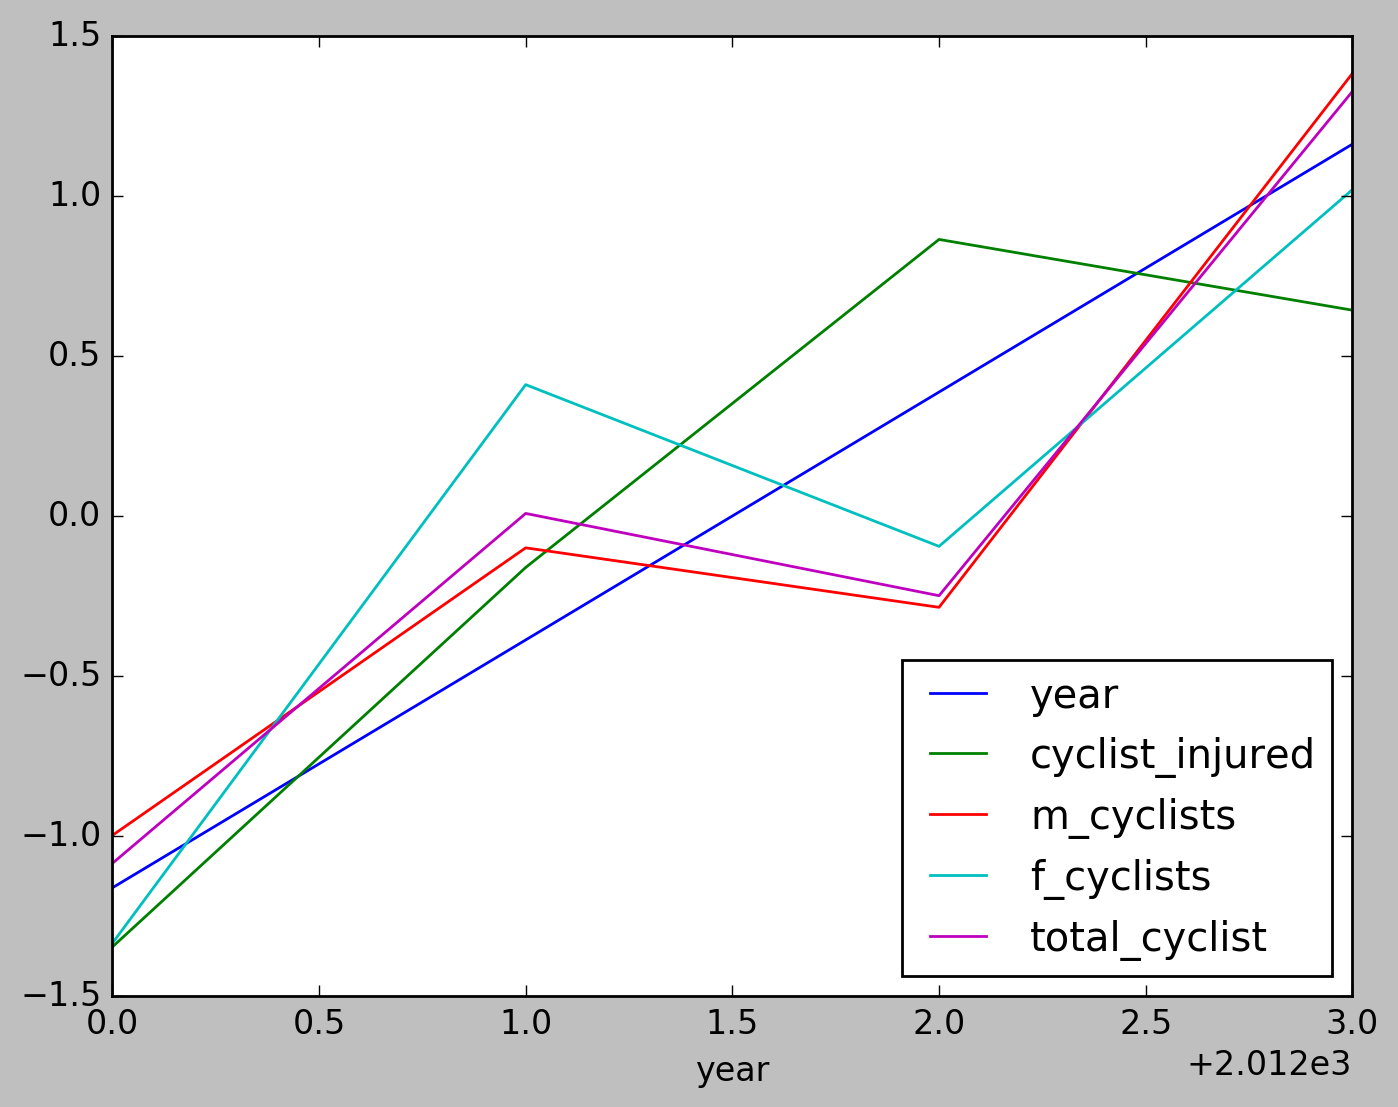

In [102]:
## now taking the standardized version of the dataframe

NY_std = (NY_groupby - NY_groupby.mean()) / (NY_groupby.std())
# NY_std.drop('year',axis=1, inplace=True) 
NY_std.index = NY_groupby['year']
plt.style.use('classic')
NY_std.plot()
plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [108]:
NYC_data

,DATE,TIME,BOROUGH,ZIP_CODE,LATITUDE,LONGITUDE,LOCATION,ON_STREET_NAME,CROSS_STREET_NAME,OFF_STREET_NAME,...,_Max_VisibilityMiles,_Mean_VisibilityMiles,_Min_VisibilityMiles,_Max_Wind_SpeedMPH,_Mean_Wind_SpeedMPH,_Max_Gust_SpeedMPH,PrecipitationIn,_CloudCover,_Events,_WindDirDegrees<br_/>
471884,2014-10-25,22,0,0.0,0.000000,0.000000,0,BRIGHTON BEACH AVENUE,BRIGHTON 1 PLACE,0,...,10.0,10.0,10.0,13.0,6.0,26.0,0.01,1.0,0,277<br />
258666,2013-10-13,13,0,0.0,0.000000,0.000000,0,135 STREET,ROCKAWAY BOULEVARD,0,...,10.0,10.0,10.0,17.0,9.0,26.0,0.00,6.0,0,73<br />
236832,2013-09-05,15,0,0.0,0.000000,0.000000,0,0,0,0,...,10.0,10.0,10.0,13.0,6.0,19.0,0.00,1.0,0,307<br />
6444,2012-07-12,10,MANHATTAN,10022.0,40.757382,-73.966702,"(40.7573816, -73.9667018)",EAST 54 STREET,2 AVENUE,0,...,10.0,10.0,10.0,10.0,3.0,20.0,0.00,1.0,0,195<br />
303788,2013-12-31,12,QUEENS,11101.0,40.745238,-73.937696,"(40.7452378, -73.9376959)",THOMSON AVENUE,SKILLMAN AVENUE,0,...,10.0,10.0,8.0,17.0,6.0,28.0,T,3.0,0,292<br />
568084,2015-04-16,10,BROOKLYN,11205.0,40.696418,-73.959769,"(40.6964184, -73.9597686)",PARK AVENUE,KENT AVENUE,0,...,10.0,10.0,10.0,16.0,7.0,21.0,0.00,0.0,0,108<br />
335899,2014-02-27,9,MANHATTAN,10011.0,40.748891,-74.007023,"(40.7488912, -74.0070233)",WEST 23 STREET,11 AVENUE,0,...,10.0,10.0,6.0,21.0,8.0,39.0,0.00,3.0,0,275<br />
919029,2016-11-04,15,QUEENS,11691.0,0.000000,0.000000,0,ROCKAWAY BEACH BOULEVARD,BEACH 48 STREET,0,...,10.0,10.0,10.0,12.0,5.0,18.0,0.00,1.0,0,320<br />
333902,2014-02-24,15,BROOKLYN,11230.0,40.635240,-73.967628,"(40.6352397, -73.9676275)",CONEY ISLAND AVENUE,18 AVENUE,0,...,10.0,10.0,10.0,17.0,9.0,28.0,0.00,3.0,0,295<br />
599470,2015-06-06,12,0,0.0,0.000000,0.000000,0,0,0,0,...,10.0,6.0,1.0,9.0,5.0,22.0,0.19,5.0,Rain,328<br />


In [155]:
## seasonal analysis:

## I wanted to separate my data into different segments so that I could compare certain features/trends across the 5
## years.

NY_spring_13 = segment_func(NY_merged_samp, '03/20/2013', '06/21/2013')
NY_spring_14 = segment_func(NY_merged_samp, '03/20/2014', '06/21/2014')
NY_spring_15 = segment_func(NY_merged_samp, '03/20/2015', '06/21/2015')
NY_spring_16 = segment_func(NY_merged_samp, '03/20/2016', '06/21/2016')
NY_summer_13 = segment_func(NY_merged_samp, '06/22/2013', '09/22/2013')
NY_summer_14 = segment_func(NY_merged_samp, '06/22/2014', '09/22/2014')
NY_summer_15 = segment_func(NY_merged_samp, '06/22/2015', '09/22/2015')
NY_summer_16 = segment_func(NY_merged_samp, '06/22/2016', '09/22/2016')
NY_fall_13 = segment_func(NY_merged_samp, '09/23/2013', '12/21/2013')
NY_fall_14 = segment_func(NY_merged_samp, '09/23/2014', '12/21/2014')
NY_fall_15 = segment_func(NY_merged_samp, '09/23/2015', '12/21/2015')
NY_fall_16 = segment_func(NY_merged_samp, '09/23/2016', '12/21/2016')
NY_winter_13a = segment_func(NY_merged_samp, '01/01/2013', '03/19/2013')
NY_winter_13b = segment_func(NY_merged_samp, '12/22/2013', '12/31/2013')
NY_winter_14a = segment_func(NY_merged_samp, '01/01/2014', '03/19/2014')
NY_winter_14b = segment_func(NY_merged_samp, '12/22/2014', '12/31/2014')
NY_winter_15a = segment_func(NY_merged_samp, '01/01/2015', '03/19/2015')
NY_winter_15b = segment_func(NY_merged_samp, '12/22/2015', '12/31/2015')
NY_winter_16a = segment_func(NY_merged_samp, '01/01/2016', '03/19/2016')
NY_winter_16b = segment_func(NY_merged_samp, '12/22/2016', '12/31/2016')

NY_spring = NY_spring_13.append(NY_spring_14.append(NY_spring_15.append(NY_spring_16)))
NY_summer = NY_summer_13.append(NY_summer_14.append(NY_summer_15.append(NY_summer_16)))
NY_fall = NY_fall_13.append(NY_fall_14.append(NY_fall_15.append(NY_fall_16)))
NY_winter_a = NY_winter_13a.append(NY_winter_14a.append(NY_winter_15a.append(NY_winter_16a)))
NY_winter_b = NY_winter_13b.append(NY_winter_14b.append(NY_winter_15b.append(NY_winter_16b)))

NY_spring['month'] = month_extract(NY_spring['DATE'])
NY_summer['month'] = month_extract(NY_summer['DATE'])
NY_winter_a['month'] = month_extract(NY_winter_a['DATE'])
NY_winter_b['month'] = month_extract(NY_winter_b['DATE'])
NY_fall['month'] = month_extract(NY_fall['DATE'])

In [156]:
## renaming the columns of the seasonal dataframes so can distinguish them when plotting

NY_spring.rename(columns={'injuries':'spring_injuries','precip':'spring_precip'}, inplace=True)
NY_summer.rename(columns={'injuries':'summer_injuries','precip':'summer_precip'}, inplace=True)
NY_winter_a.rename(columns={'injuries':'winter_a_injuries','precip':'winter_a_precip'}, inplace=True)
NY_winter_b.rename(columns={'injuries':'winter_b_injuries','precip':'winter_b_precip'}, inplace=True)
NY_fall.rename(columns={'injuries':'fall_injuries','precip':'fall_precip'}, inplace=True)

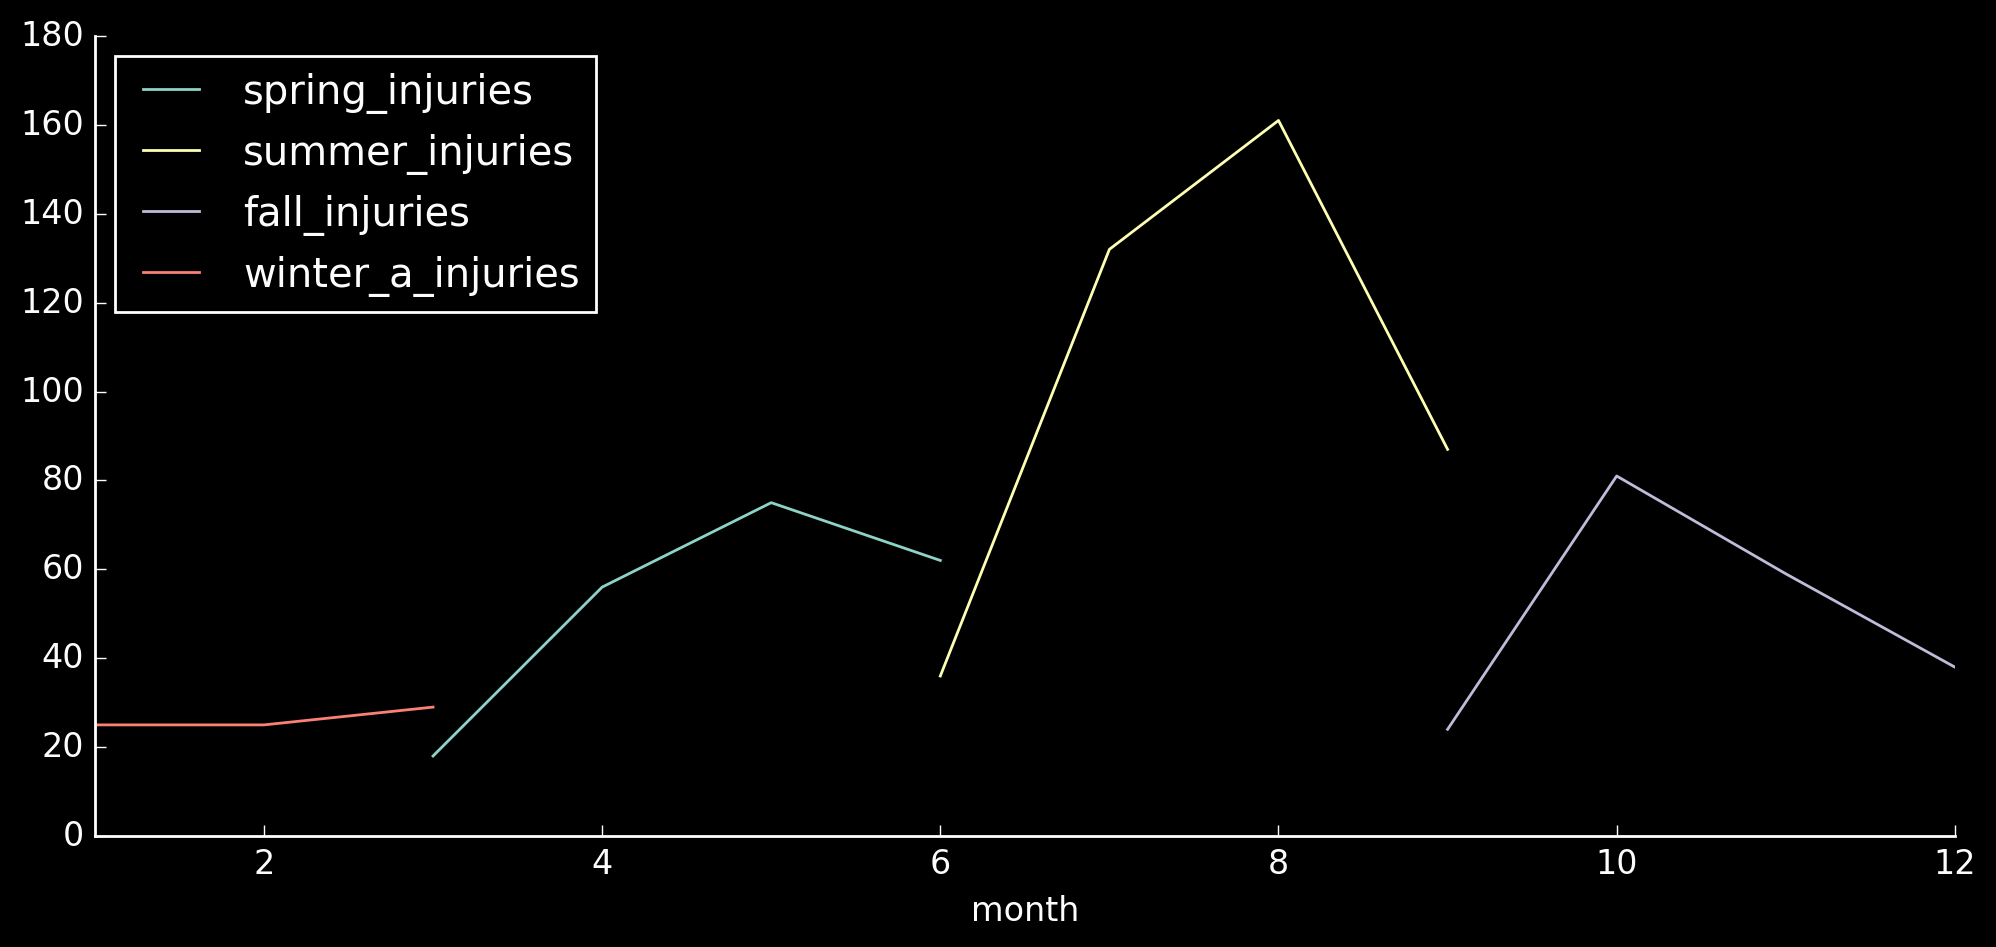

In [158]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))

NY_spring.groupby(['month'])['spring_injuries'].sum().plot()
NY_summer.groupby(['month'])['summer_injuries'].sum().plot()
NY_fall.groupby(['month'])['fall_injuries'].sum().plot()
NY_winter_a.groupby(['month'])['winter_a_injuries'].sum().plot()

plt.legend(loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

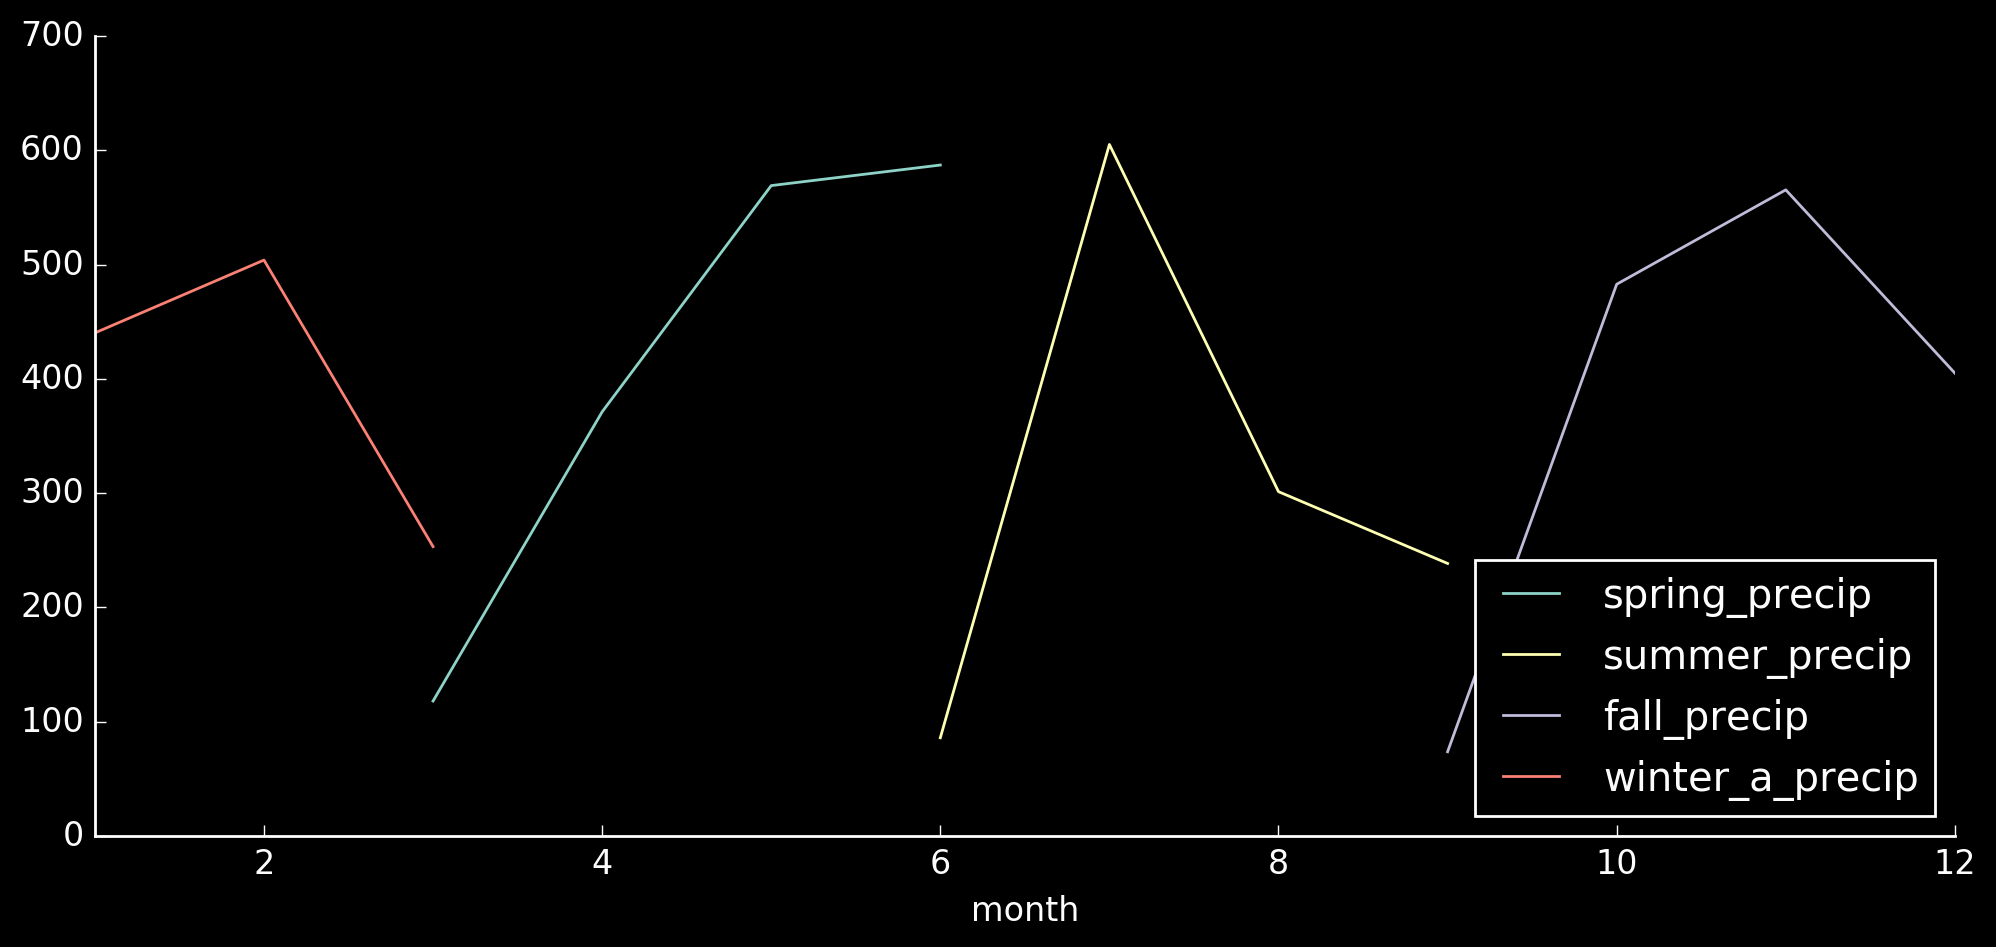

In [146]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))

NY_spring.groupby(['month'])['spring_precip'].sum().plot()
NY_summer.groupby(['month'])['summer_precip'].sum().plot()
NY_fall.groupby(['month'])['fall_precip'].sum().plot()
NY_winter_a.groupby(['month'])['winter_a_precip'].sum().plot()

plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [160]:
##separating my sample dataframe out into years to perform timeseries analysis...

bike_2012 = segment_func(NY_merged_samp, '01/01/2012', '12/31/2012')
bike_2013 = segment_func(NY_merged_samp, '01/01/2013', '12/31/2013')
bike_2014 = segment_func(NY_merged_samp, '01/01/2014', '12/31/2014')
bike_2015 = segment_func(NY_merged_samp, '01/01/2015', '12/31/2015')
bike_2016 = segment_func(NY_merged_samp, '01/01/2016', '12/31/2016')

bike_2012.rename(columns={'precip':'2012_precip'}, inplace=True)
bike_2013.rename(columns={'precip':'2013_precip'}, inplace=True)
bike_2014.rename(columns={'precip':'2014_precip'}, inplace=True)
bike_2015.rename(columns={'precip':'2015_precip'}, inplace=True)
bike_2016.rename(columns={'precip':'2016_precip'}, inplace=True)

//anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


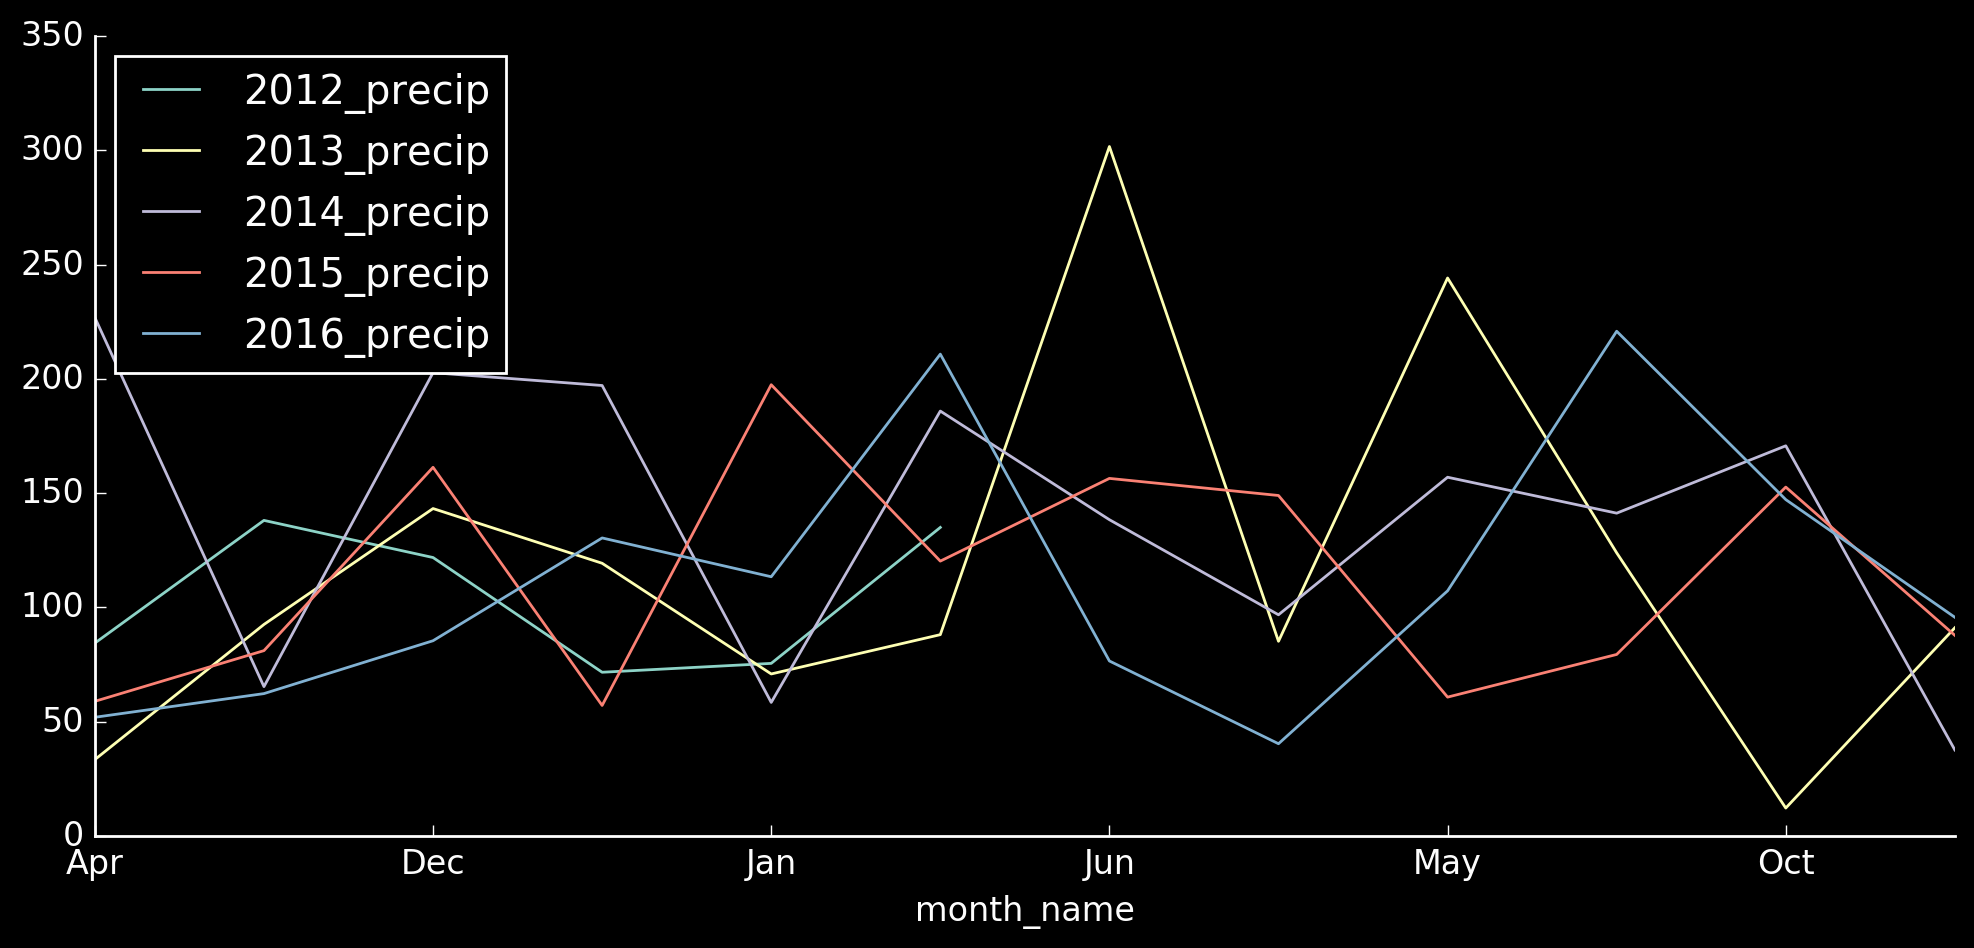

In [163]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))

bike_2012.groupby(['month_name'])['2012_precip'].sum().plot()
bike_2013.groupby(['month_name'])['2013_precip'].sum().plot()
bike_2014.groupby(['month_name'])['2014_precip'].sum().plot()
bike_2015.groupby(['month_name'])['2015_precip'].sum().plot()
bike_2016.groupby(['month_name'])['2016_precip'].sum().plot()

plt.legend(loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [688]:
## setting up the borough dataframes for plotting
borough_mask_12 = bike_2012[bike_2012['BOROUGH'] != 0]
borough_mask_13 = bike_2013[bike_2013['BOROUGH'] != 0]
borough_mask_14 = bike_2014[bike_2014['BOROUGH'] != 0]
borough_mask_15 = bike_2015[bike_2015['BOROUGH'] != 0]
borough_mask_16 = bike_2016[bike_2016['BOROUGH'] != 0]

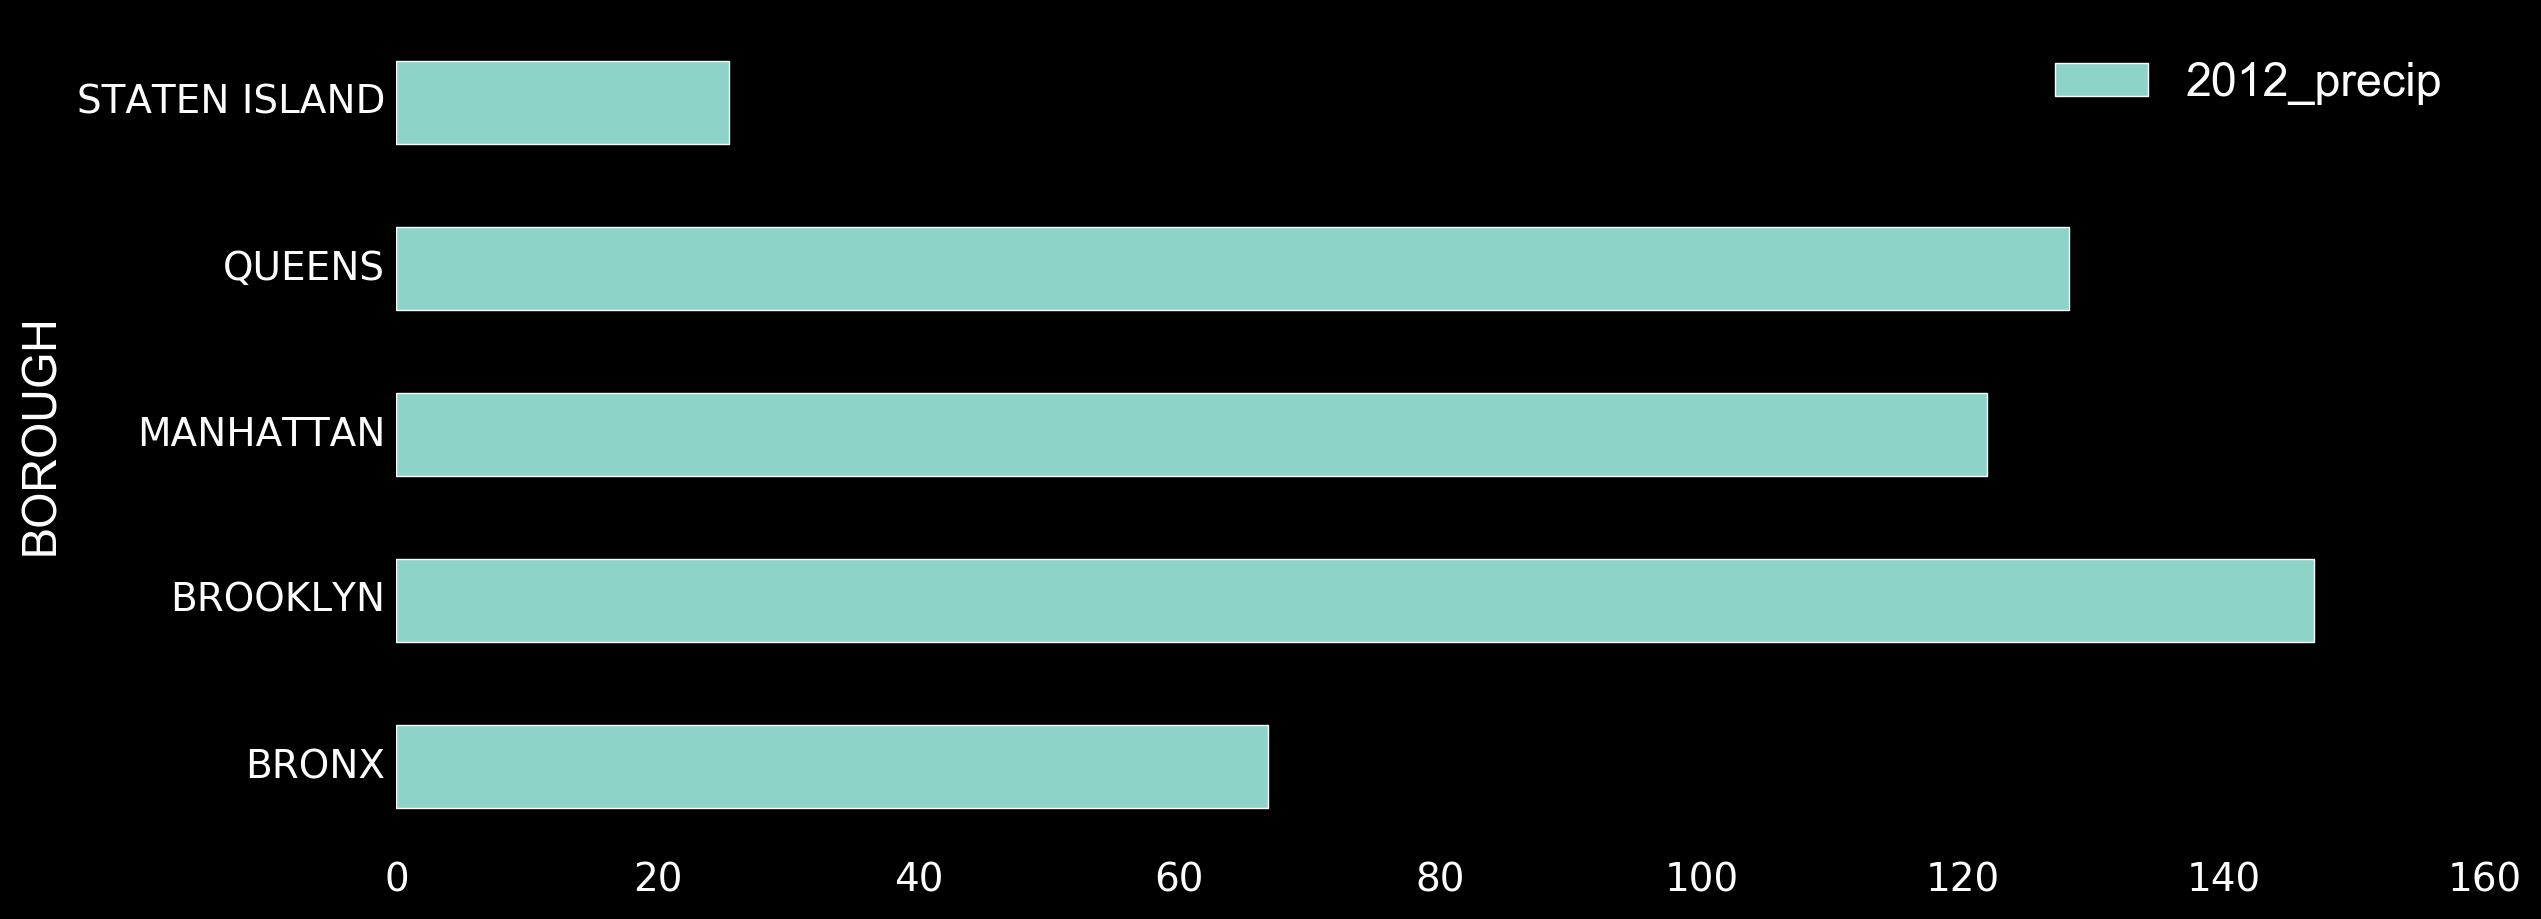

In [757]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
borough_mask_12.groupby(['BOROUGH'])['2012_precip'].sum().plot.barh(stacked=True)
ax.legend(loc='upper right')

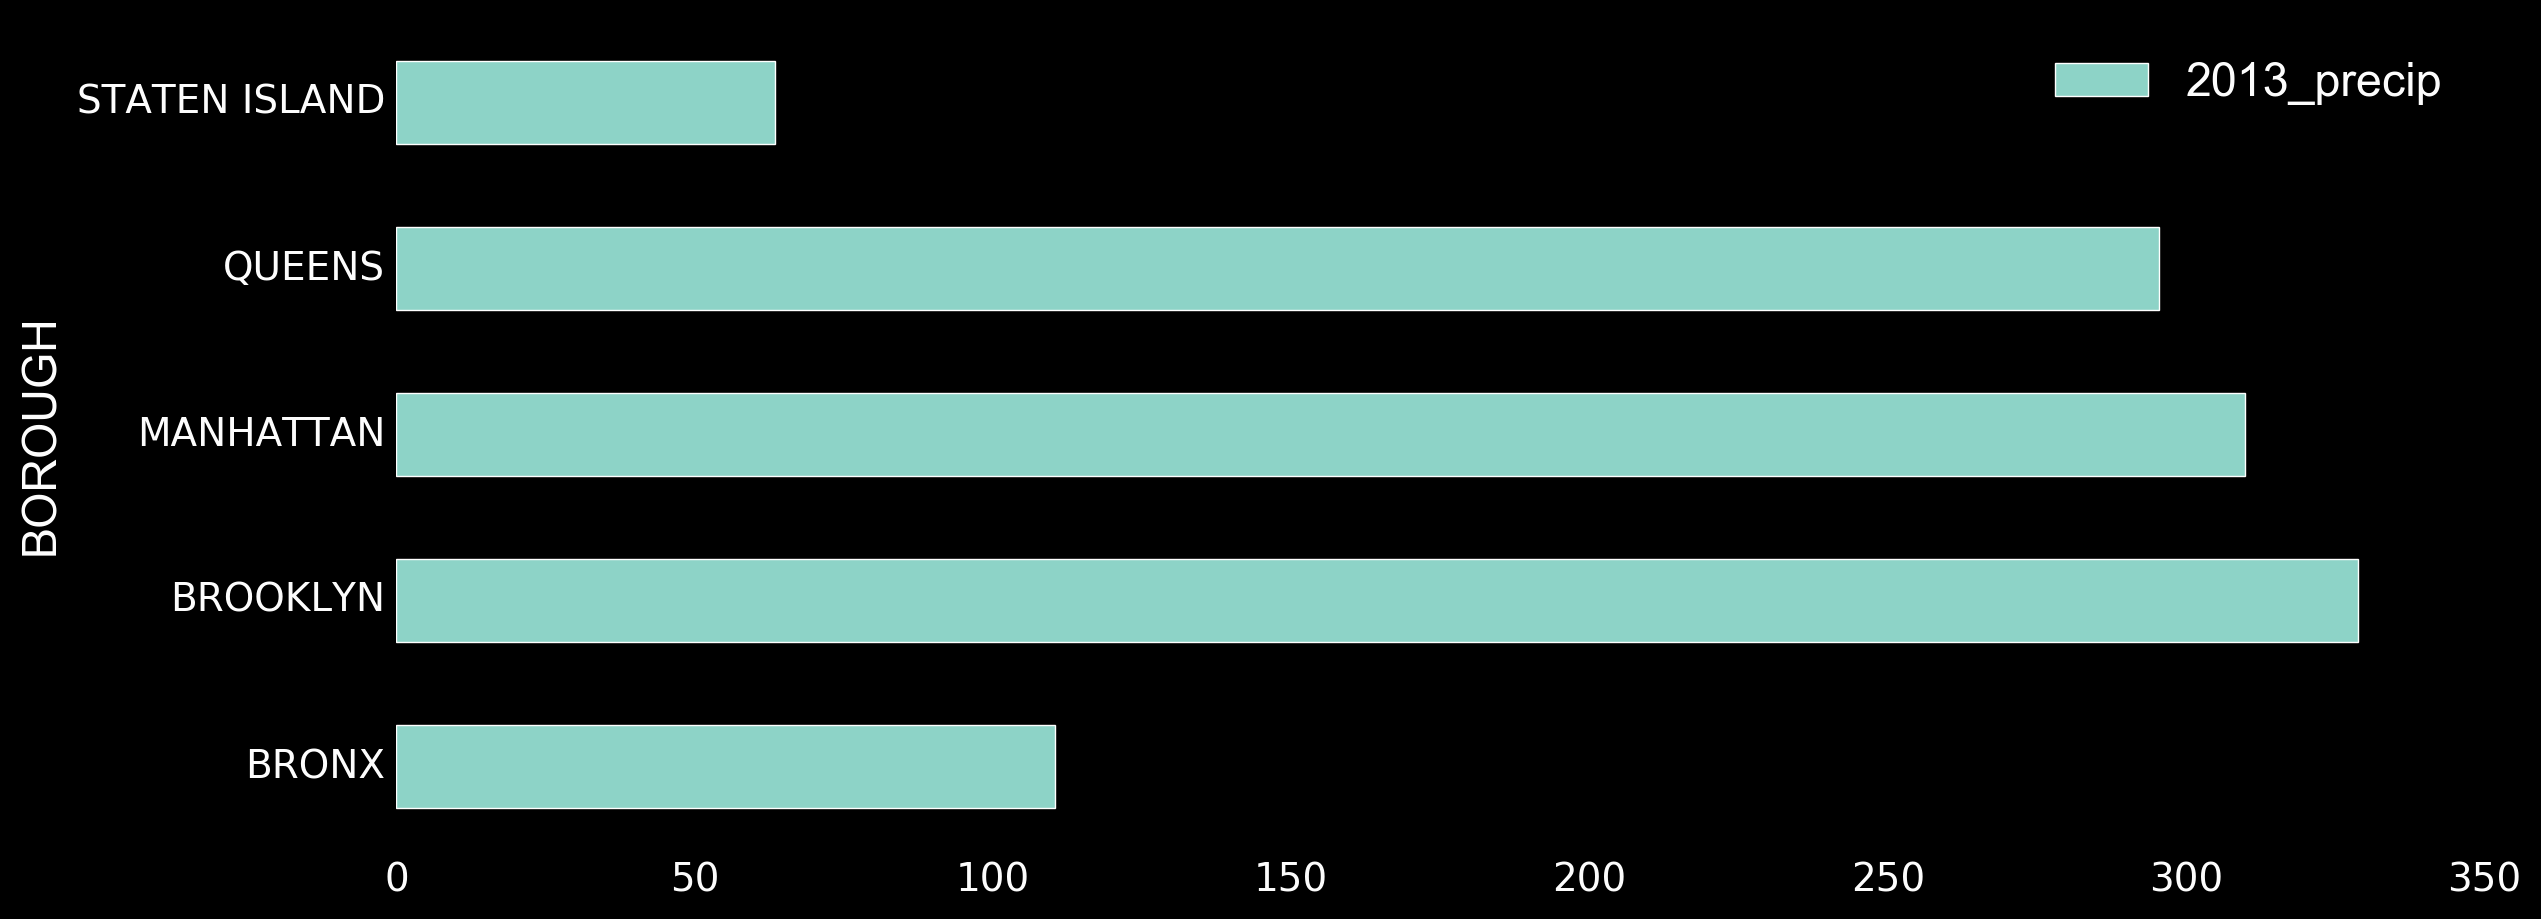

In [758]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
borough_mask_13.groupby(['BOROUGH'])['2013_precip'].sum().plot.barh(stacked=True)
ax.legend(loc='upper right')

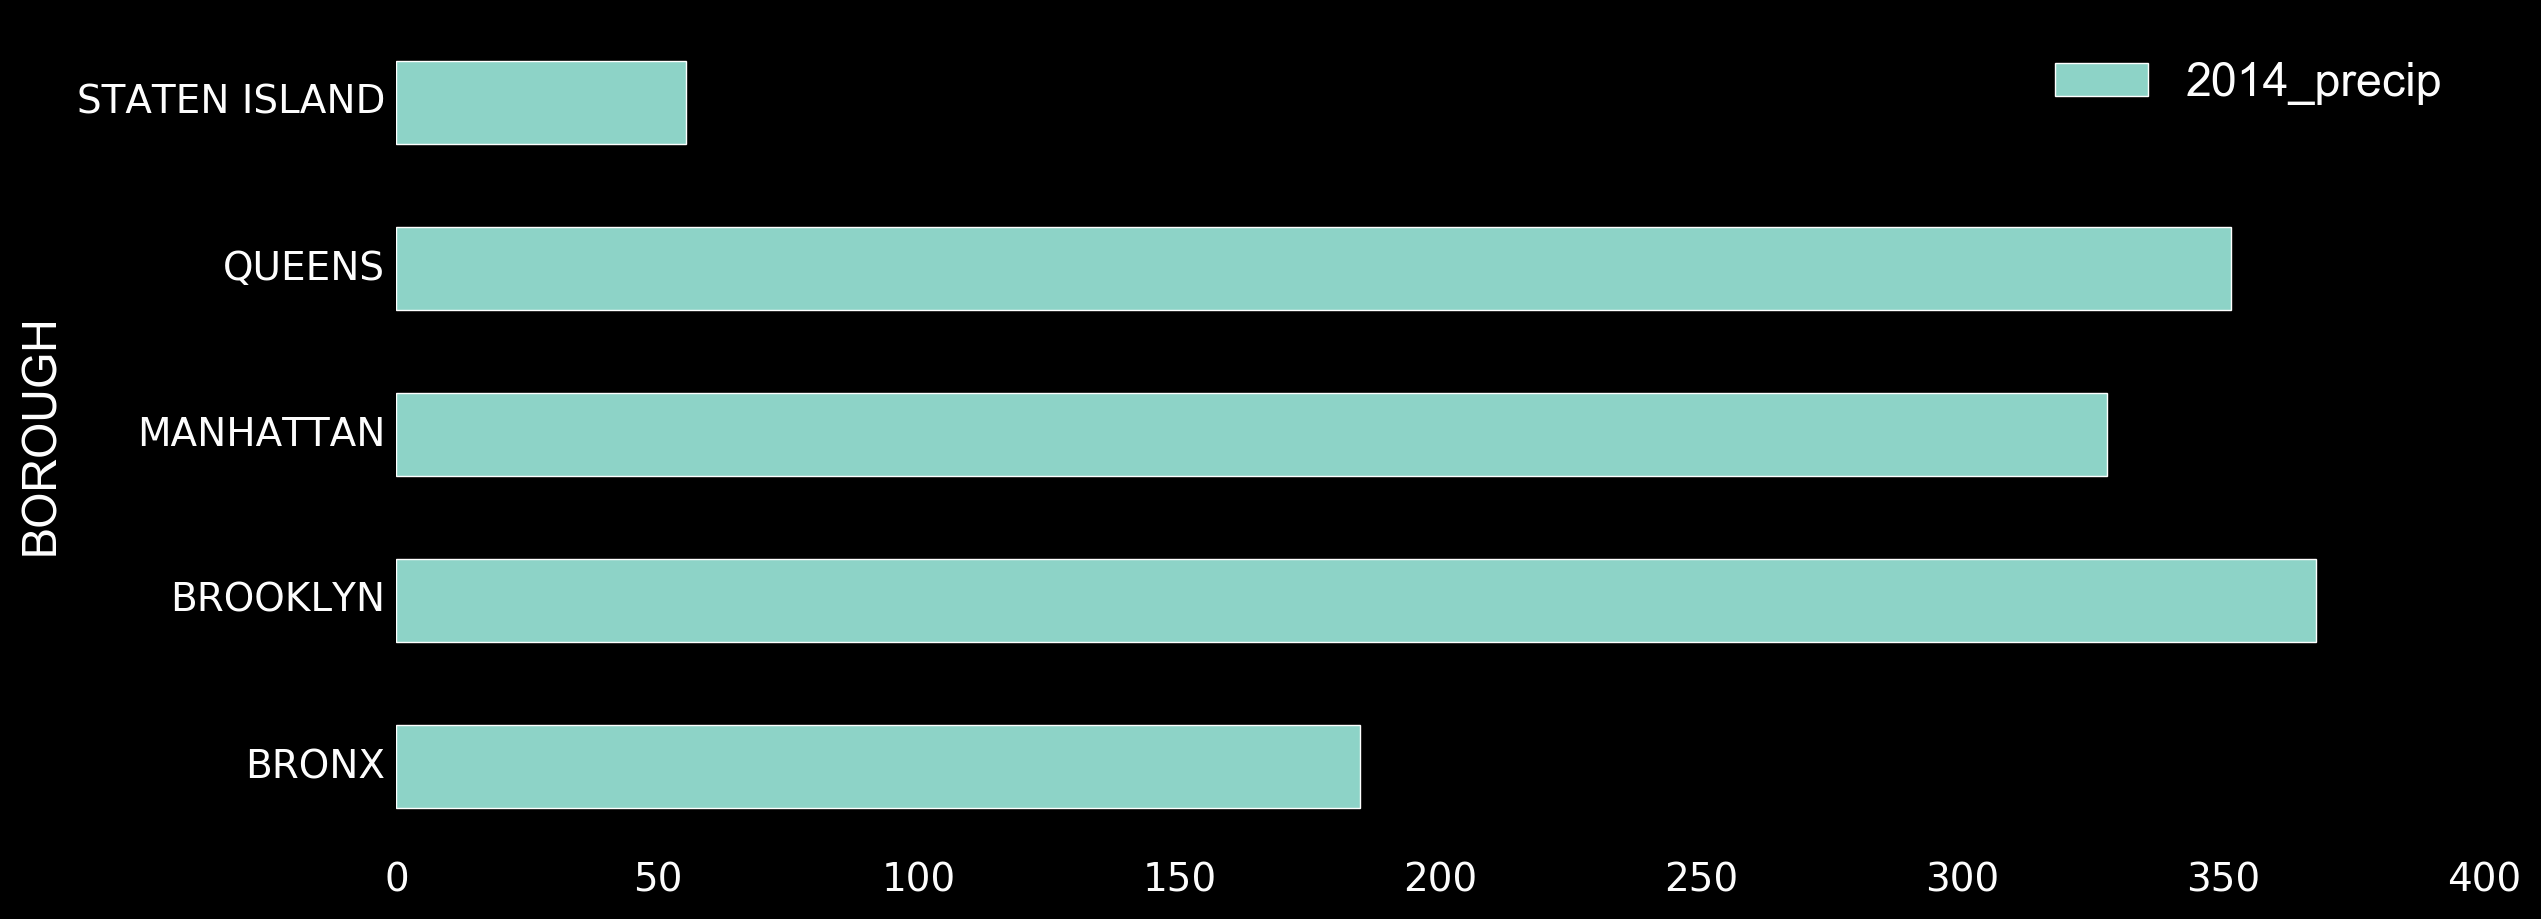

In [759]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
borough_mask_14.groupby(['BOROUGH'])['2014_precip'].sum().plot.barh(stacked=True)
ax.legend(loc='upper right')

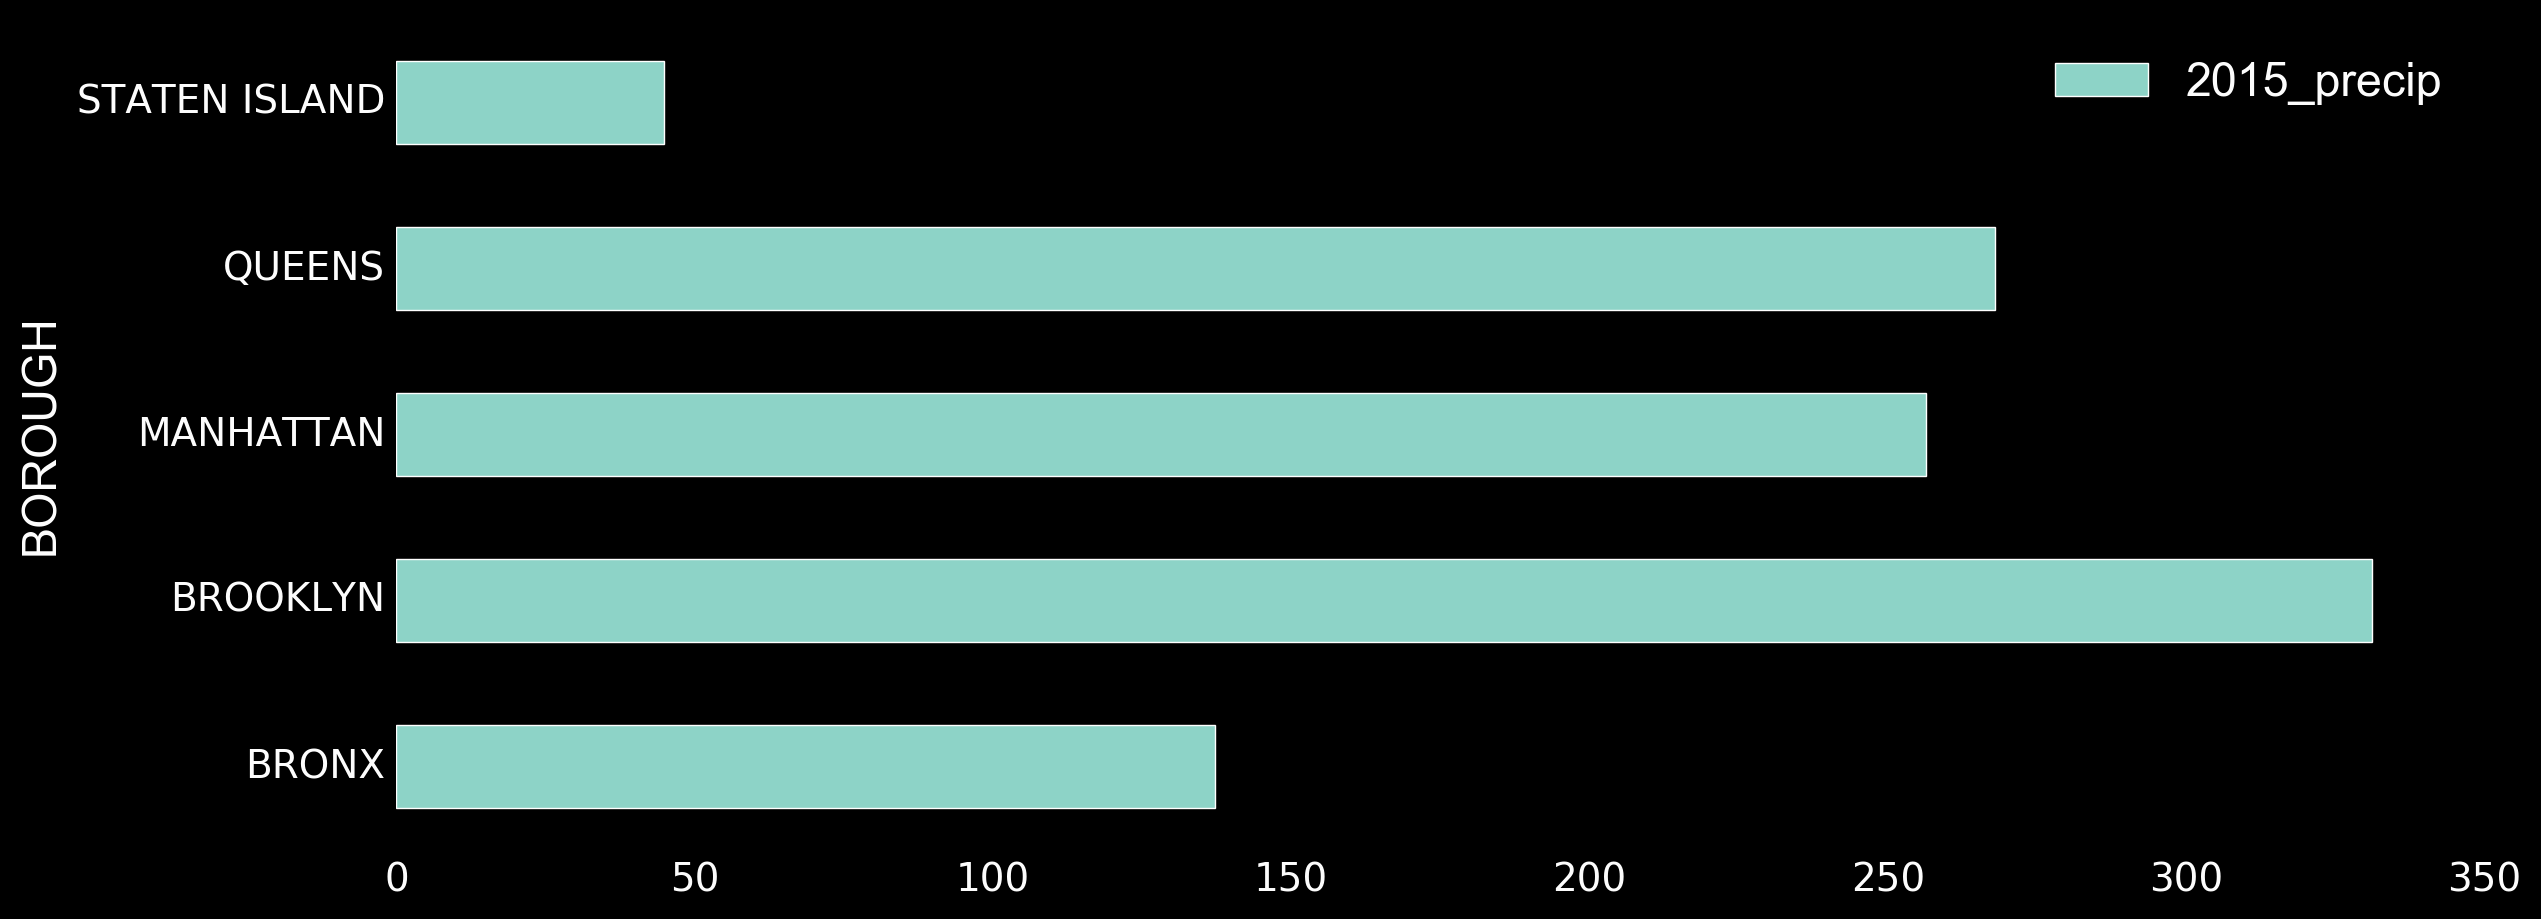

In [760]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
borough_mask_15.groupby(['BOROUGH'])['2015_precip'].sum().plot.barh(stacked=True)
ax.legend(loc='upper right')

NameError: name 'borough_mask_16' is not defined

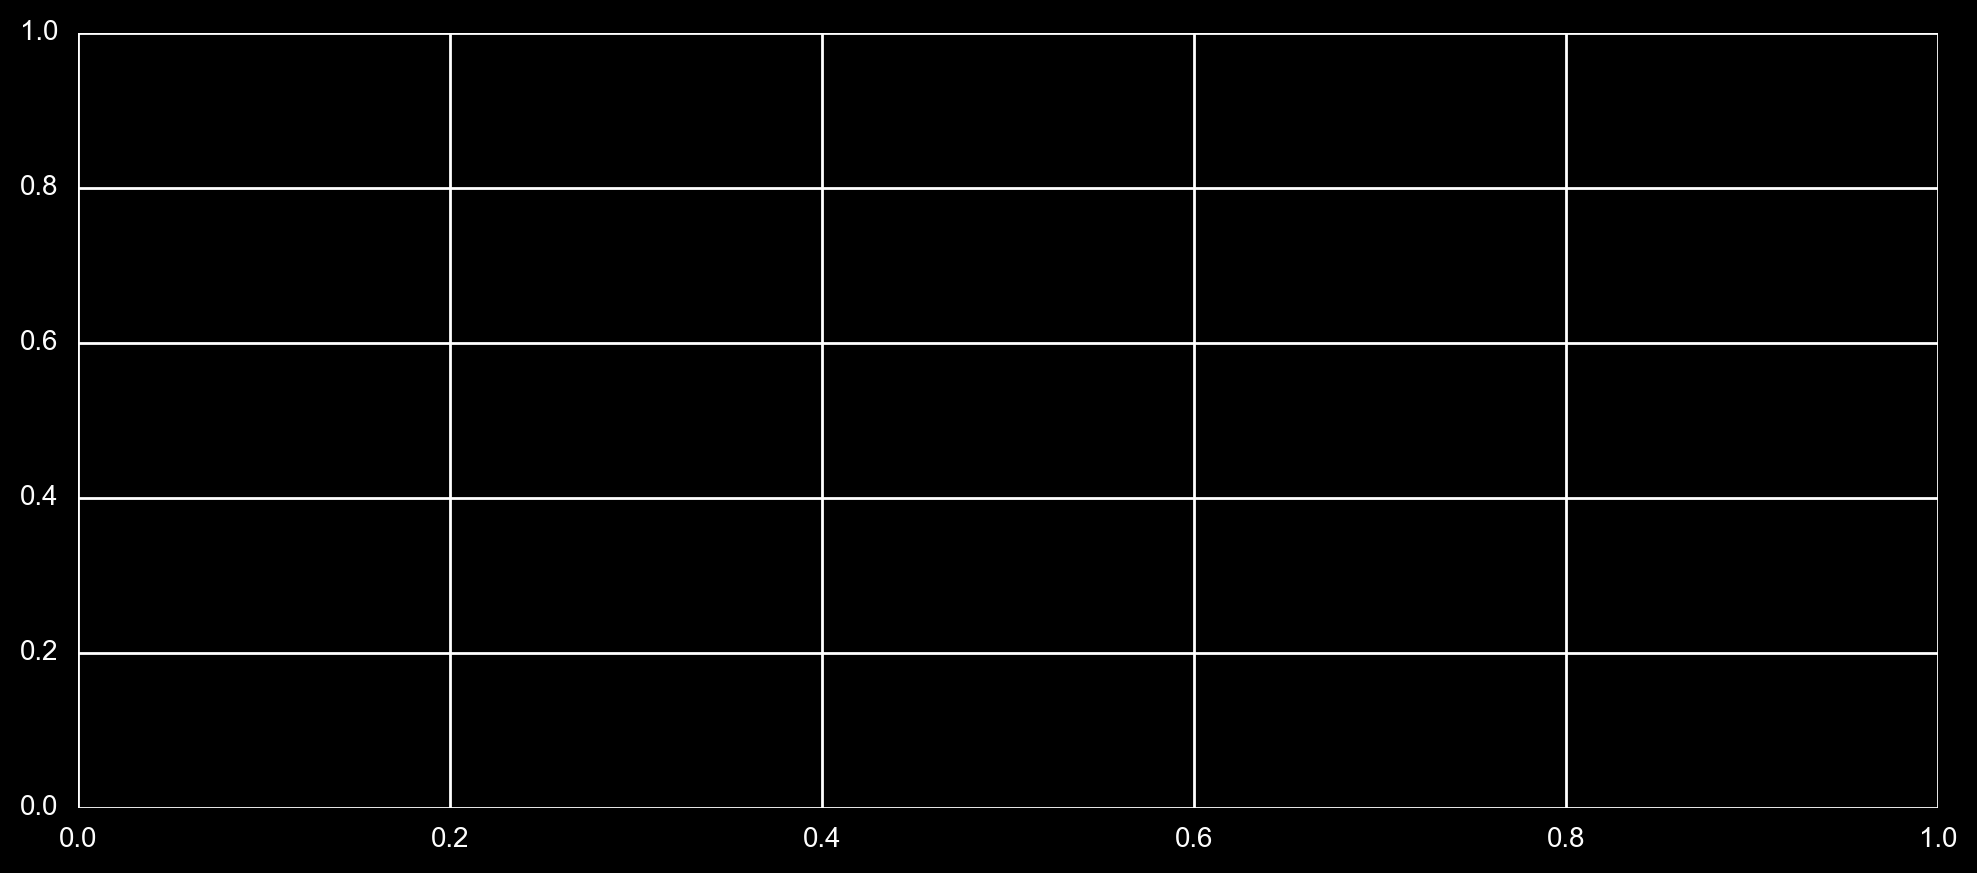

In [33]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
borough_mask_16.groupby(['BOROUGH'])['2016_precip'].sum().plot.barh(stacked=True)
ax.legend(loc='upper right')

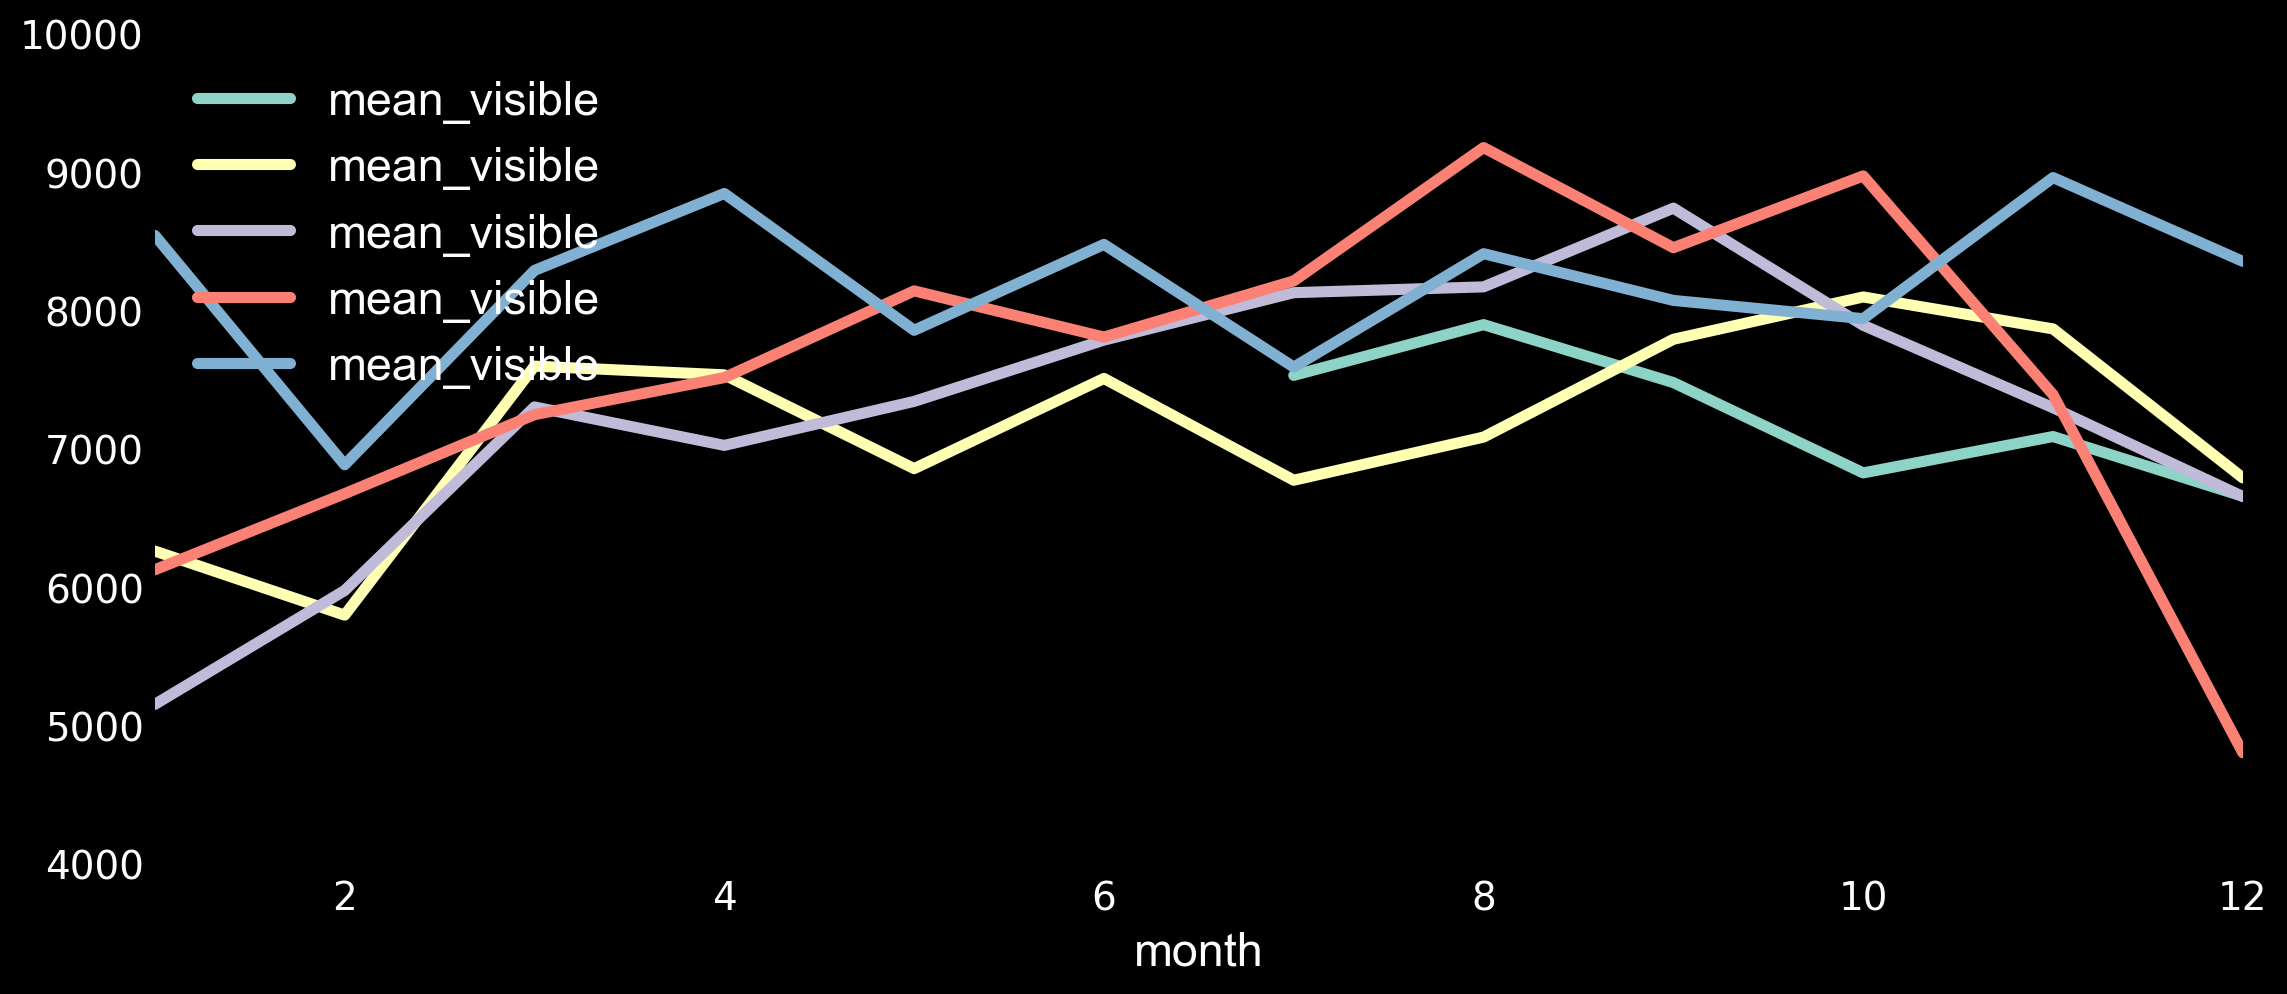

In [803]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12,5))

bike_2012.groupby(['month'])['mean_visible'].sum().plot()
bike_2013.groupby(['month'])['mean_visible'].sum().plot()
bike_2014.groupby(['month'])['mean_visible'].sum().plot()
bike_2015.groupby(['month'])['mean_visible'].sum().plot()
bike_2016.groupby(['month'])['mean_visible'].sum().plot()


ax.legend(loc='upper left')

In [786]:
NY_merged_samp.head()

,DATE,TIME,BOROUGH,ZIP_CODE,LATITUDE,LONGITUDE,LOCATION,ON_STREET_NAME,CROSS_STREET_NAME,OFF_STREET_NAME,...,_Events,_WindDirDegrees<br_/>,borough_cat,precip_scale,month,injuries_binary,temp_cat,dew_cat,humid_cat,year
471884,2014-10-25,22,0,0.0,0.000000,0.000000,0,BRIGHTON BEACH AVENUE,BRIGHTON 1 PLACE,0,...,0,277<br />,0,1,10,0,4,3,4,2014
258666,2013-10-13,13,0,0.0,0.000000,0.000000,0,135 STREET,ROCKAWAY BOULEVARD,0,...,0,73<br />,0,0,10,0,5,4,5,2013
236832,2013-09-05,15,0,0.0,0.000000,0.000000,0,0,0,0,...,0,307<br />,0,0,9,0,5,4,4,2013
6444,2012-07-12,10,MANHATTAN,10022.0,40.757382,-73.966702,"(40.7573816, -73.9667018)",EAST 54 STREET,2 AVENUE,0,...,0,195<br />,2,0,7,0,5,4,4,2012
303788,2013-12-31,12,QUEENS,11101.0,40.745238,-73.937696,"(40.7452378, -73.9376959)",THOMSON AVENUE,SKILLMAN AVENUE,0,...,0,292<br />,3,0,12,0,3,2,4,2013


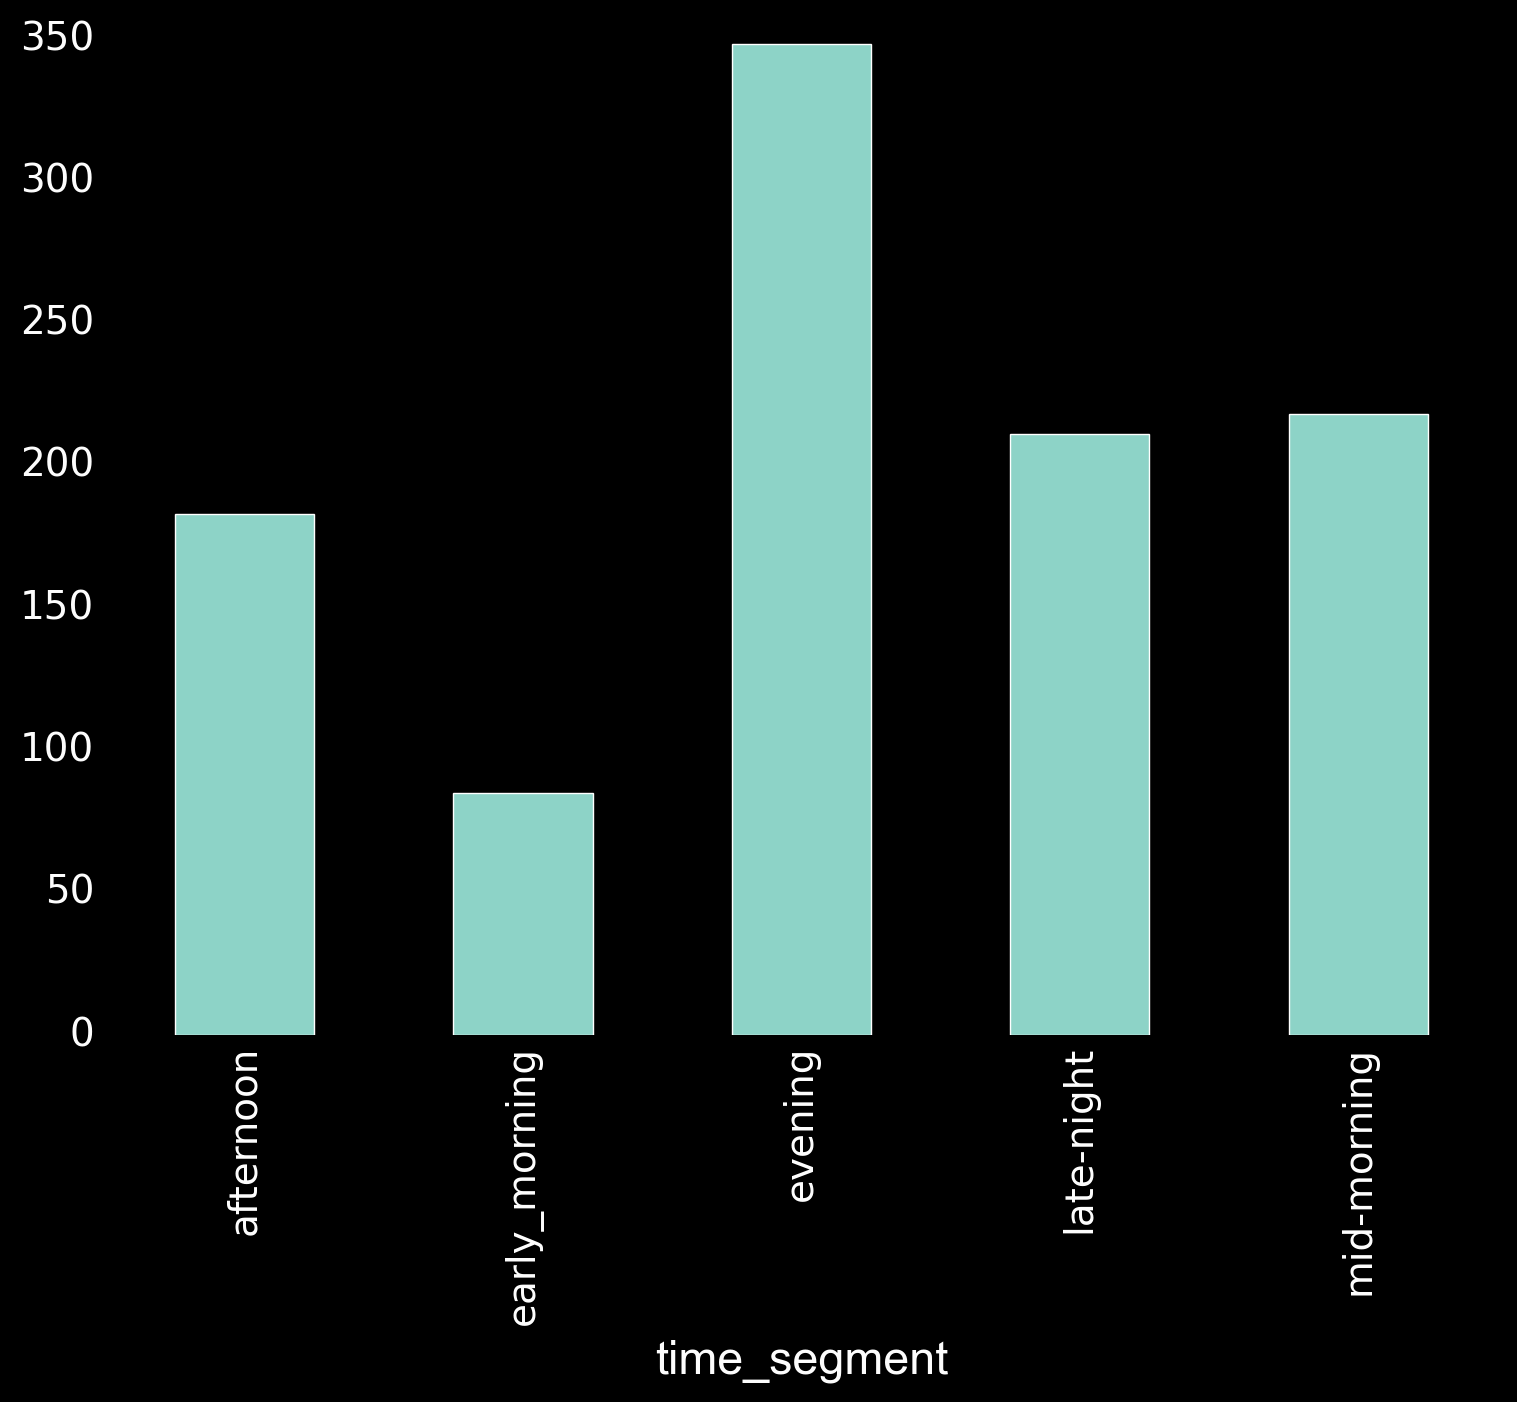

In [802]:
## plotting the number of cycling injuries per segment of day (between 1am and 6am = 'early morning',
## between 6am and 12pm = 'mid-morning', between 12pm and 3pm = 'afternoon', between 3pm and 7pm = 'evening' and
## between 7pm and midnight = 'late-night')

NY_merged_samp.groupby(['time_segment'])['injuries'].sum().plot(kind='bar')

In [111]:
##standardizing my data so I can plot and visualize the trends...

##2012
bike_2012_std = bike_2012[['NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'PrecipitationIn']]
bike_2012_std = (bike_2012_std - bike_2012_std.mean()) / bike_2012_std.std()
bike_2012_std['MONTH'] = bike_2012['MONTH']

##2013
bike_2013_std = bike_2013[['NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'PrecipitationIn']]
bike_2013_std = (bike_2013_std - bike_2013_std.mean()) / bike_2013_std.std()
bike_2013_std['MONTH'] = bike_2013['MONTH']

##2014
bike_2014_std = bike_2014[['NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'PrecipitationIn']]
bike_2014_std = (bike_2014_std - bike_2014_std.mean()) / bike_2014_std.std()
bike_2014_std['MONTH'] = bike_2014['MONTH']

##2015
bike_2015_std = bike_2015[['NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'PrecipitationIn']]
bike_2015_std = (bike_2015_std - bike_2015_std.mean()) / bike_2015_std.std()
bike_2015_std['MONTH'] = bike_2015['MONTH']

##2016
bike_2016_std = bike_2016[['NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'PrecipitationIn']]
bike_2016_std = (bike_2016_std - bike_2016_std.mean()) / bike_2016_std.std()
bike_2016_std['MONTH'] = bike_2016['MONTH']

In [9]:
NY_merged_samp.columns = NY_merged_samp.columns.str.replace(' ', '_')
NY_merged_samp.fillna(0, inplace=True)
NY_merged_samp['DATE'] = pd.to_datetime(NY_merged_samp['DATE'])
NY_merged_samp = NY_merged_samp.sort_values(by='DATE')
NY_merged_samp = NY_merged_samp[NY_merged_samp['DATE'] < '01/01/2017']

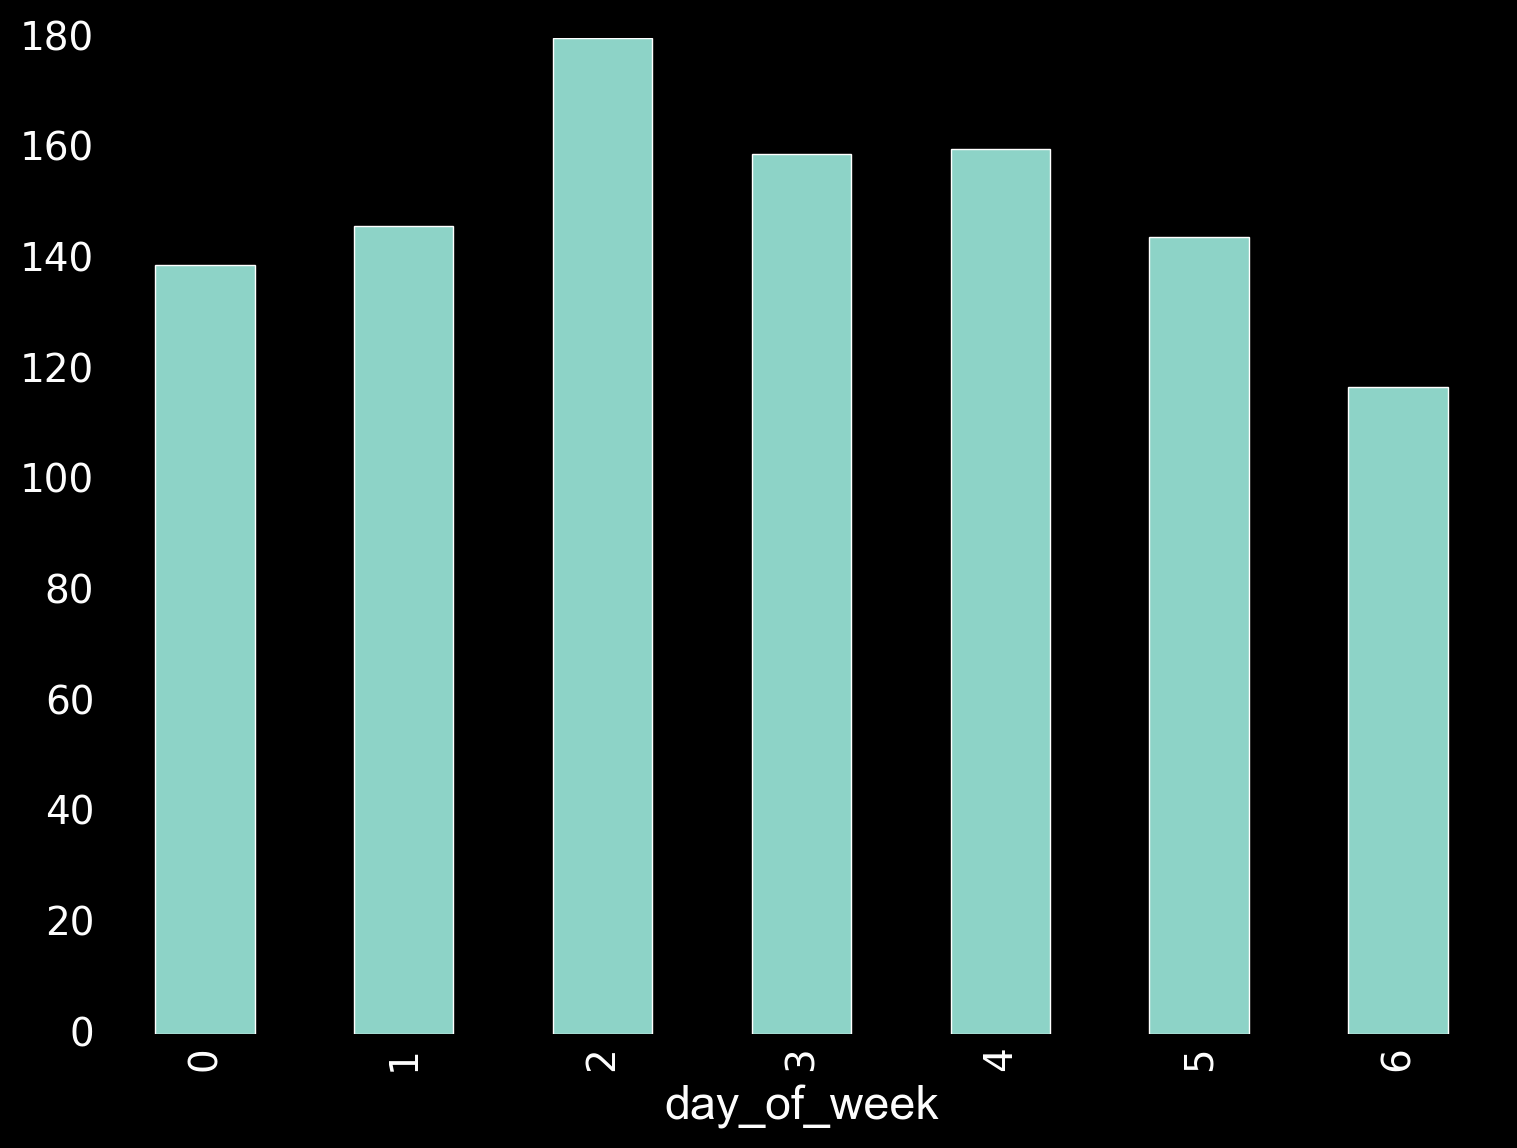

In [814]:
NY_merged_samp.groupby(['day_of_week'])['injuries'].sum().plot(kind='bar')

In [11]:
NY_merged_samp['PrecipitationIn'].replace(to_replace='T', value=0.00, inplace=True)
NY_merged_samp['PrecipitationIn'] = NY_merged_samp['PrecipitationIn'].astype(float)

In [12]:
## setting up my features to include in my regression model

NY_merged_samp['borough_cat'] = borough(NY_merged_samp['BOROUGH'])
NY_merged_samp['precip_scale'] = precip(NY_merged_samp['PrecipitationIn'])
NY_merged_samp['MONTH'] = month_extract(NY_merged_samp['DATE'])
NY_merged_samp['CYCLISTS_INJURED'] = binary(NY_merged_samp['NUMBER_OF_CYCLIST_INJURED'])
NY_merged_samp['temp_cat'] = temp(NY_merged_samp['Mean_TemperatureF'])
NY_merged_samp['dew_cat'] = temp(NY_merged_samp['MeanDew_PointF'])
NY_merged_samp['humid_cat'] = temp(NY_merged_samp['_Mean_Humidity'])

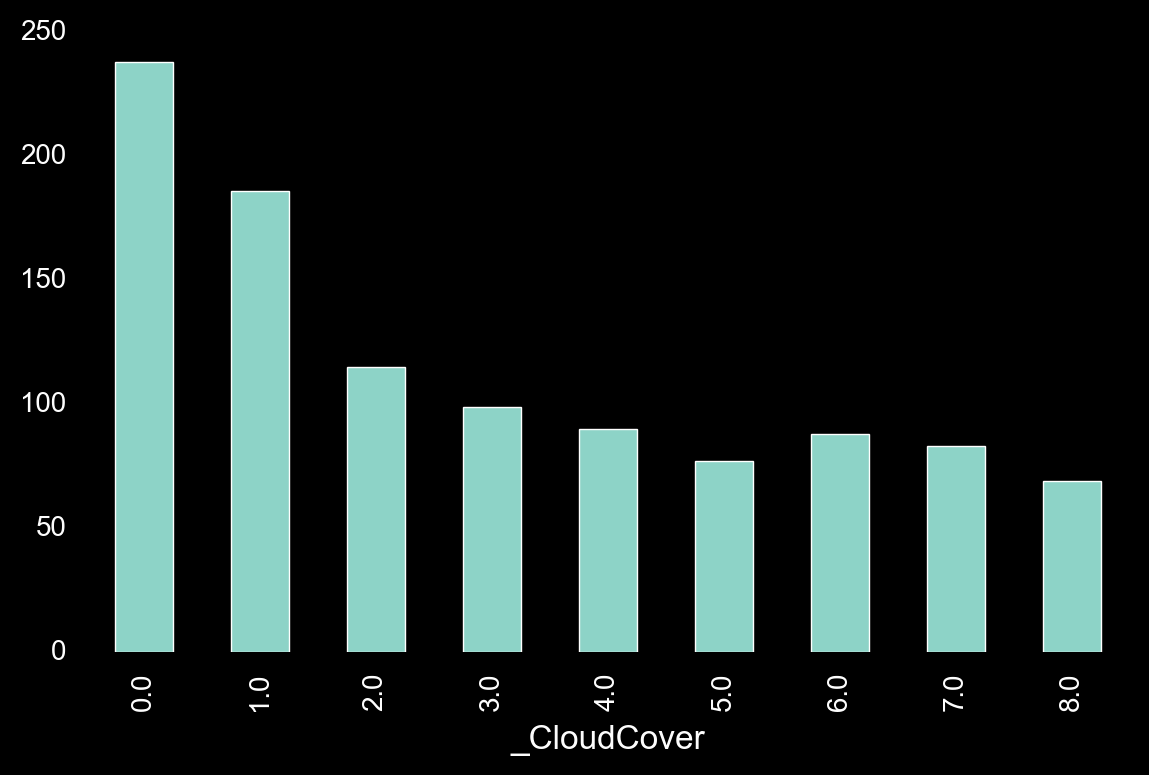

In [13]:
plt.style.use('dark_background')

NY_merged_samp.groupby(['_CloudCover'])['NUMBER_OF_CYCLIST_INJURED'].sum().plot(kind='bar')

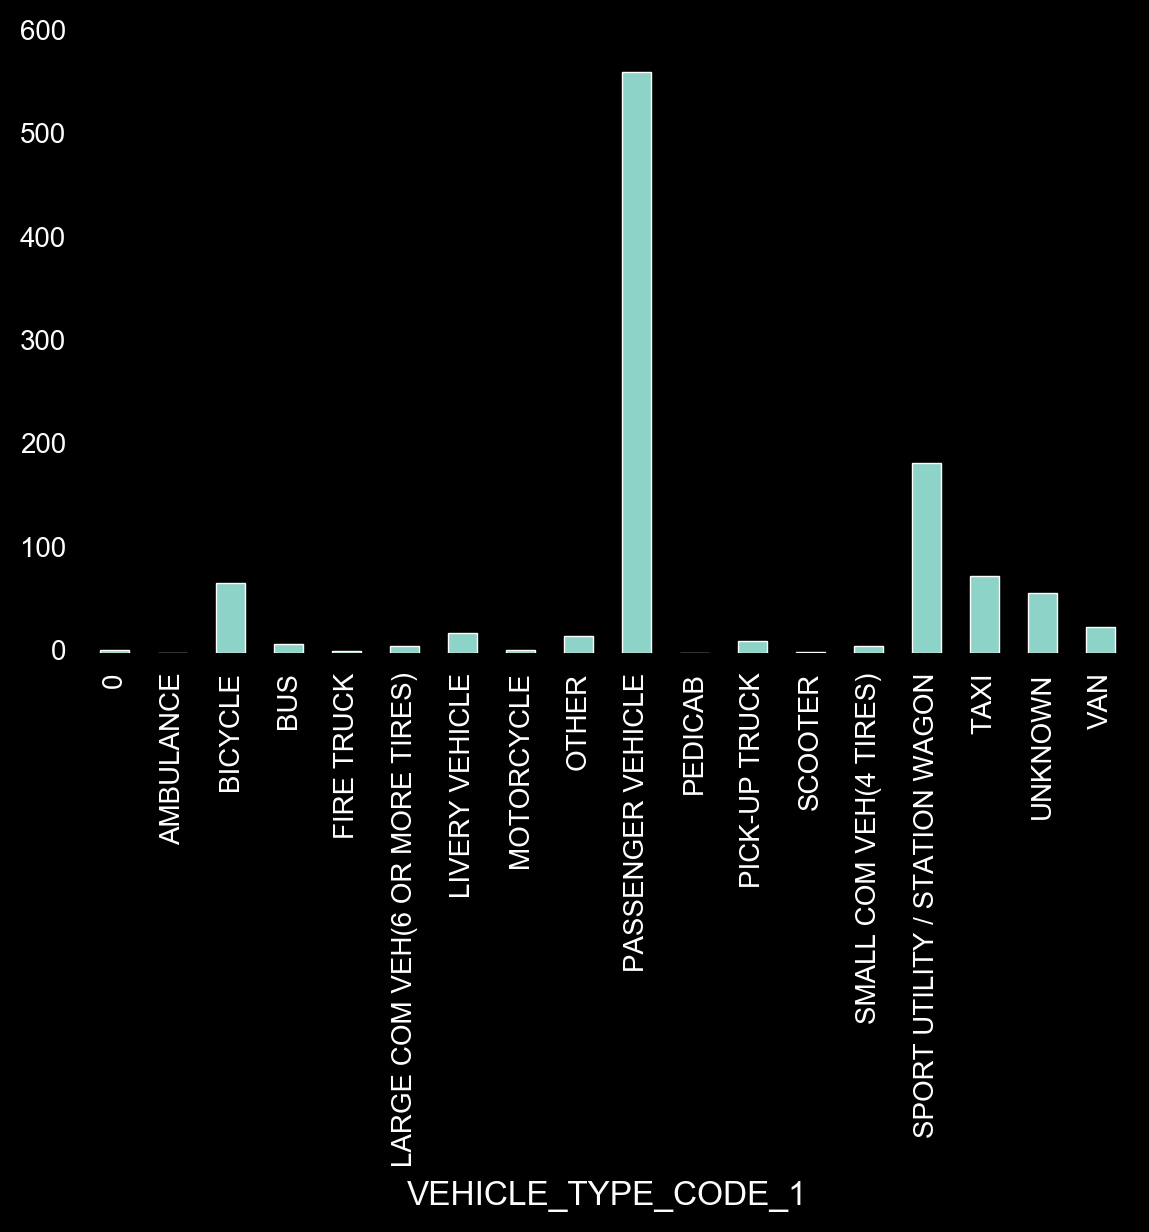

In [16]:
plt.style.use('dark_background')

NY_merged_samp.groupby(['VEHICLE_TYPE_CODE_1'])['NUMBER_OF_CYCLIST_INJURED'].sum().plot(kind='bar')

In [14]:
NY_merged_samp.shape

(47739, 58)

In [71]:
# consolidate into fewer categories:
# dew_cat
# humid_cat
# cloud cover
# wind speed

In [135]:
NY_merged_samp['wind_cat'] = wind(NY_merged_samp['_Mean_Wind_SpeedMPH'])

In [163]:
tmp = NY_merged_samp[['MONTH','precip_scale','borough_cat','TIME','temp_cat','wind_cat','NUMBER_OF_CYCLIST_INJURED']]
tmp.columns = ['month','precip','borough','hour','temp','wind','injured']

In [164]:
tmp = tmp.groupby(['month','precip','borough','hour','wind'])['injured'].agg(np.sum)
tmp = tmp.reset_index()
tmp.head()

,month,precip,borough,hour,wind,injured
0,1,0,0,0,1,0
1,1,0,0,0,2,0
2,1,0,0,0,3,0
3,1,0,0,1,1,0
4,1,0,0,1,2,0


In [165]:
tmp.corr()

,month,precip,borough,hour,wind,injured
month,1.000000,0.034779,-0.002715,0.000941,-0.107116,0.074288
precip,0.034779,1.000000,-0.060735,0.047358,0.002201,-0.116452
borough,-0.002715,-0.060735,1.000000,0.040822,-0.053799,-0.071977
hour,0.000941,0.047358,0.040822,1.000000,0.026085,0.104957
wind,-0.107116,0.002201,-0.053799,0.026085,1.000000,-0.149795
injured,0.074288,-0.116452,-0.071977,0.104957,-0.149795,1.000000


In [166]:
tmp.shape

(7976, 6)

In [97]:
# import itertools
# def expandgrid(*itrs):
#     product = list(itertools.product(*itrs))
#     return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}


# months = NY_merged_samp['MONTH'].unique()
# pre_scale = NY_merged_samp['precip_scale'].unique()
# borough = NY_merged_samp['borough_cat'].unique()
# hour = NY_merged_samp.TIME.unique()
# temp_cat = NY_merged_samp.temp_cat.unique()
# dew_cat = NY_merged_samp.dew_cat.unique()
# humid_cat = NY_merged_samp.humid_cat.unique()
# cloud_cover = NY_merged_samp._CloudCover.unique()
# wind_speed = NY_merged_samp._Mean_Wind_SpeedMPH.unique()

# grid = expandgrid(months, pre_scale, borough, hour, temp_cat, dew_cat, humid_cat, cloud_cover, wind_speed)
# grid = pd.DataFrame(grid)
# grid.columns = ['months','precip','borough','hour', 'temp_cat', 'dew_cat', 'humid_cat', 'cloud_cover', 'wind_speed']

# grid_cols = grid.columns
# orig_cols = ['MONTH','precip_scale','borough_cat','TIME','temp_cat']

# grid['bike_injuries'] = 0.
# grid['mean_temp_cat'] = 0.
# grid['mean_dew_cat'] = 0.
# grid['mean_humid_cat'] = 0.
# grid['mean_cloud_cover'] = 0.
# grid['mean_wind_speed'] = 0.

# NY_ = NY_merged_samp[NY_merged_samp['CYCLISTS_INJURED'] > 0]

# for m in months:
#     for p in pre_scale:
#         for b in borough:
#             for h in hour:
#                 orig_mask = reduce(lambda x, y: x & y, [NY_[col] for col in orig_cols])
#                 grid_mask = reduce(lambda x, y: x & y, [grid[col] for col in grid_cols])

#                 injuries = NY_.loc[orig_mask, 'CYCLISTS_INJURED'].sum()
#                 grid.loc[grid_mask, 'bike_injuries'] = injuries
#                 grid.loc[grid_mask, 'mean_temp_cat'] = NY_loc[orig_mask, 'temp_cat'].mean()
#                 grid.loc[grid_mask, 'mean_dew_cat'] = NY_.loc[orig_mask, 'dew_cat'].mean()
#                 grid.loc[grid_mask, 'mean_humid_cat'] = NY_.loc[orig_mask, 'humid_cat'].mean()
#                 grid.loc[grid_mask, 'mean_cloud_cover'] = NY_.loc[orig_mask, 'cloud_cover'].mean()
#                 grid.loc[grid_mask, 'mean_wind_speed'] = NY_.loc[orig_mask, 'wind_speed'].mean()
                
                
              
                    
                    
                    
                    
# #                     for d in dew_cat:
# #                         for hm in humid_cat:
# #                             for c in cloud_cover:
# #                                 for w in wind_speed:

# # for m in months:
# #     NY_1 = NY_merged_samp[(NY_merged_samp['MONTH'] == m) & (NY_merged_samp['CYCLISTS_INJURED'] > 0)]
# #     for p in pre_scale:
# #         print m, p
# #         NY_2 = NY_1[NY_1['precip_scale'] == p]
# #         for b in borough:
# #             NY_3 = NY_2[NY_2['borough_cat'] == b]
# #             for h in hour:
# #                 NY_4 = NY_3[NY_3['TIME'] == h]
# #                 for t in temp_cat:
# #                     NY_5 = NY_4[NY_4['temp_cat'] == t]
# #                     for d in dew_cat:
# #                         NY_6 = NY_5[NY_5['dew_cat'] == d]
# #                         for hm in humid_cat:
# #                             NY_7 = NY_6[NY_6['humid_cat'] == hm]
# #                             for c in cloud_cover:
# #                                 NY_8 = NY_7[NY_7['cloud_cover'] == c]
# #                                 for w in wind_speed:
# #                                     ny_mask = (NY_8['wind_speed'] == w)
                        
                        
# #                                     grid_mask = ((grid.months == m) & (grid.precip == p) & 
# #                                     (grid.borough == b) & (grid.hour == h) & (grid.temp_cat == t) &
# #                                     (grid.dew_cat == d) & (grid.humid_cat == hm) & (grid.cloud_cover == c) &
# #                                     (grid.wind_speed == w))
                                    
                
# #                                     injuries = NY_3.loc[ny_mask, 'CYCLISTS_INJURED'].sum()
# #                                     grid.loc[grid_mask, 'bike_injuries'] = injuries


In [98]:
tmp.columns

Index([u'month', u'precip', u'borough', u'hour', u'injured'], dtype='object')

In [ ]:
## Logistic Regression CV

In [ ]:
## overfit the anomolies and then cross validate on the overall

In [167]:
## first I'm scaling my data

from sklearn.preprocessing import StandardScaler

scaler      =  StandardScaler()
columns     =  ['month','borough','precip','hour','wind']
tmp[columns] =  scaler.fit_transform(tmp[columns])

In [168]:
## next step- throw the model into patsy and the regression built 

formula = "injured ~ C(month) + C(borough) + C(precip) + C(hour) + C(wind) -1"
y, X = patsy.dmatrices(formula, data=tmp, return_type='dataframe')

In [169]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
model = lm.fit(X, y)
predictions  =  model.predict(X)
score = model.score(X, y)
    
print "R^2 score:", score

R^2 score: 0.120120604724


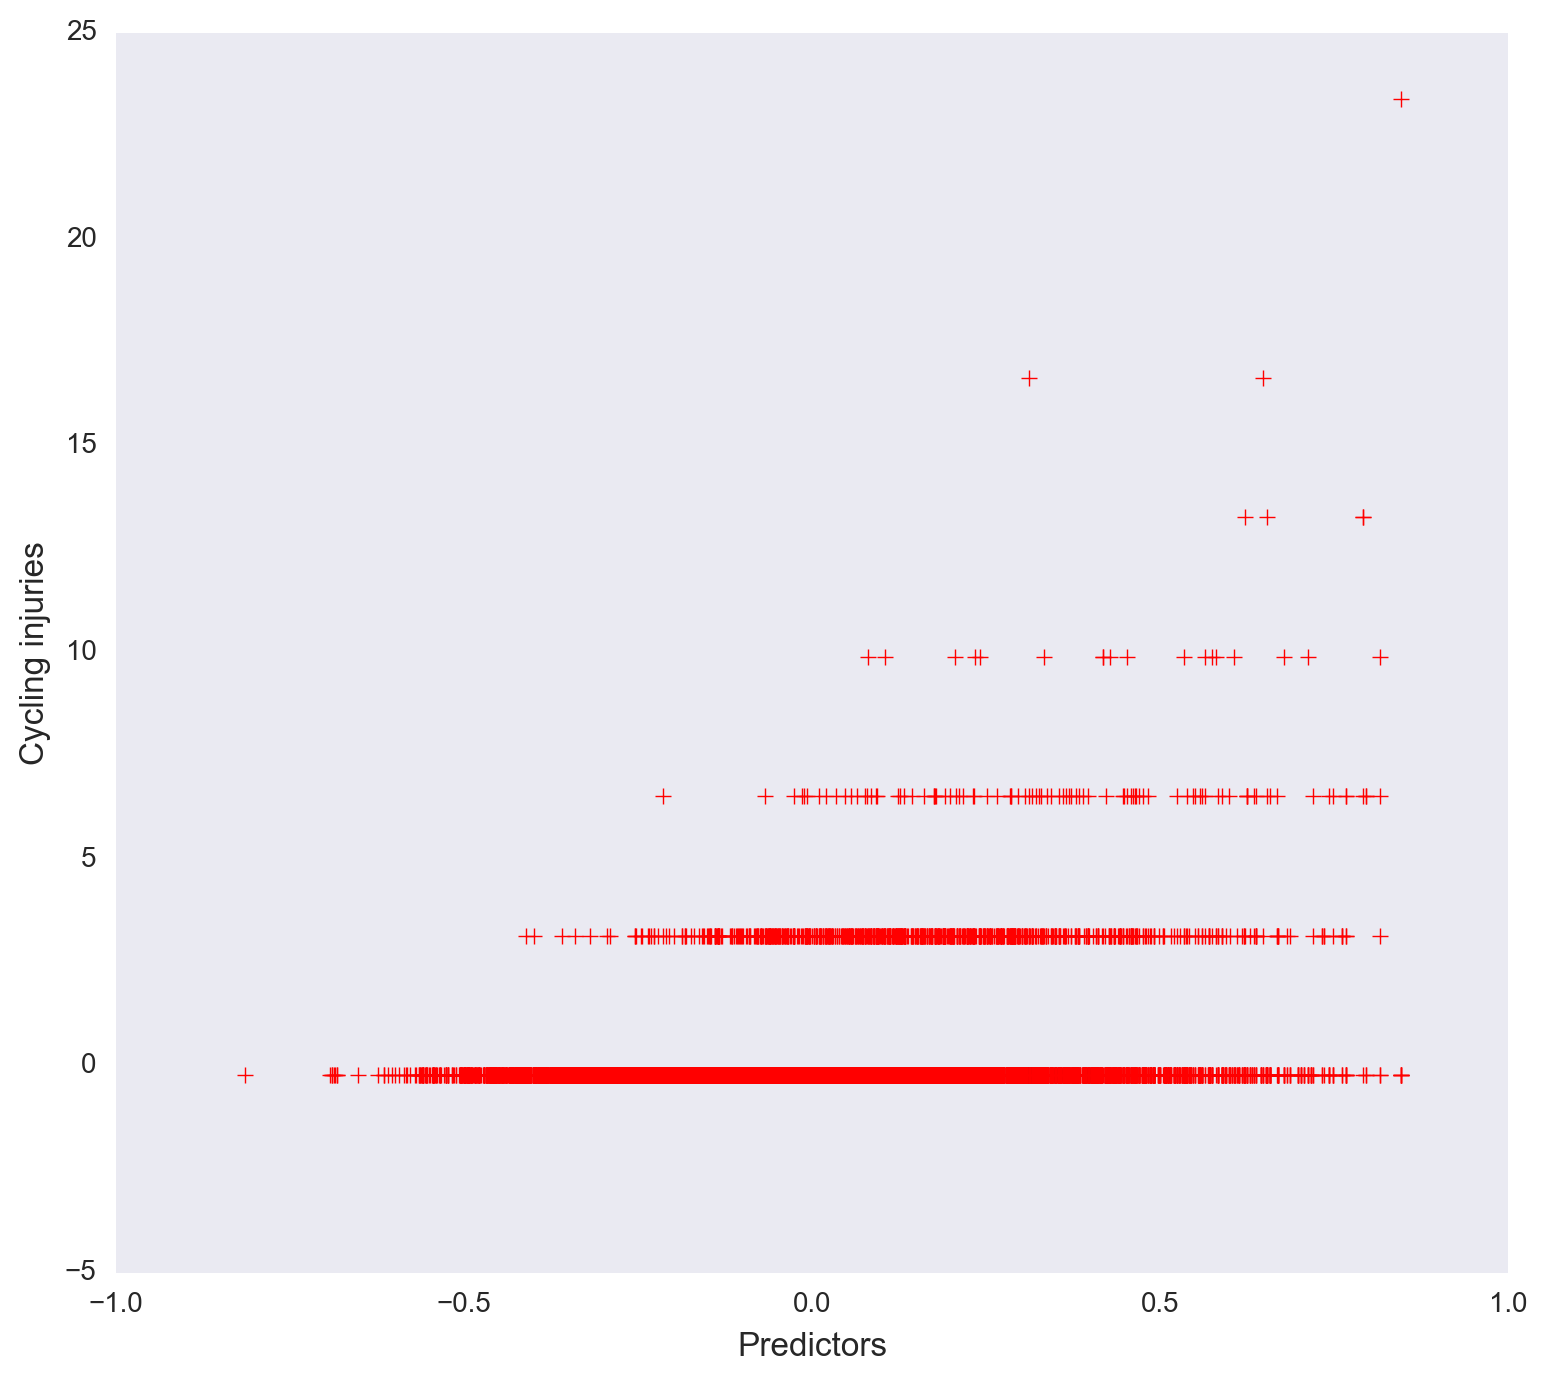

In [91]:
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predictors")
plt.ylabel("Cycling injuries")
plt.show()

In [64]:
print "MSE:", mean_squared_error(y, predictions)

print 

print "COEFS:", zip(X.columns, model.coef_)

print 

print "SCORE/R^2:", model.score(X, y)

MSE: 0.79910961297

COEFS: [('C(month)[-1.623648154336957]', array([  9.49230204e+11,   9.49230204e+11,   9.49230204e+11,
         9.49230204e+11,   9.49230204e+11,   9.49230204e+11,
         9.49230204e+11,   9.49230204e+11,   9.49230204e+11,
         9.49230204e+11,   9.49230204e+11,   9.49230204e+11,
        -3.43050003e-01,  -6.88618660e-01,  -4.99786377e-01,
        -6.77749634e-01,  -6.78226471e-01,   3.35414886e-01,
         2.31306076e-01,   1.19045258e-01,  -1.81587219e-01,
        -4.08813953e-01,  -2.55684853e-01,  -3.33417535e-01,
        -2.91832924e-01,  -3.37638617e-01,  -3.00825238e-01,
        -2.20731735e-01,  -9.12046432e-02,   3.80897522e-03,
         6.89067841e-02,  -7.70905018e-02,   7.62040615e-02,
         9.14164335e-02,   2.77613163e-01,   1.35551095e-01,
         1.87739849e-01,   3.85303974e-01,   3.74346018e-01,
         4.06289667e-01,   4.44556326e-01,   2.76505038e-01,
         4.23843026e-01,  -3.68781090e-02,  -9.85877514e-02]))]

SCORE/R^2: 0.2008903

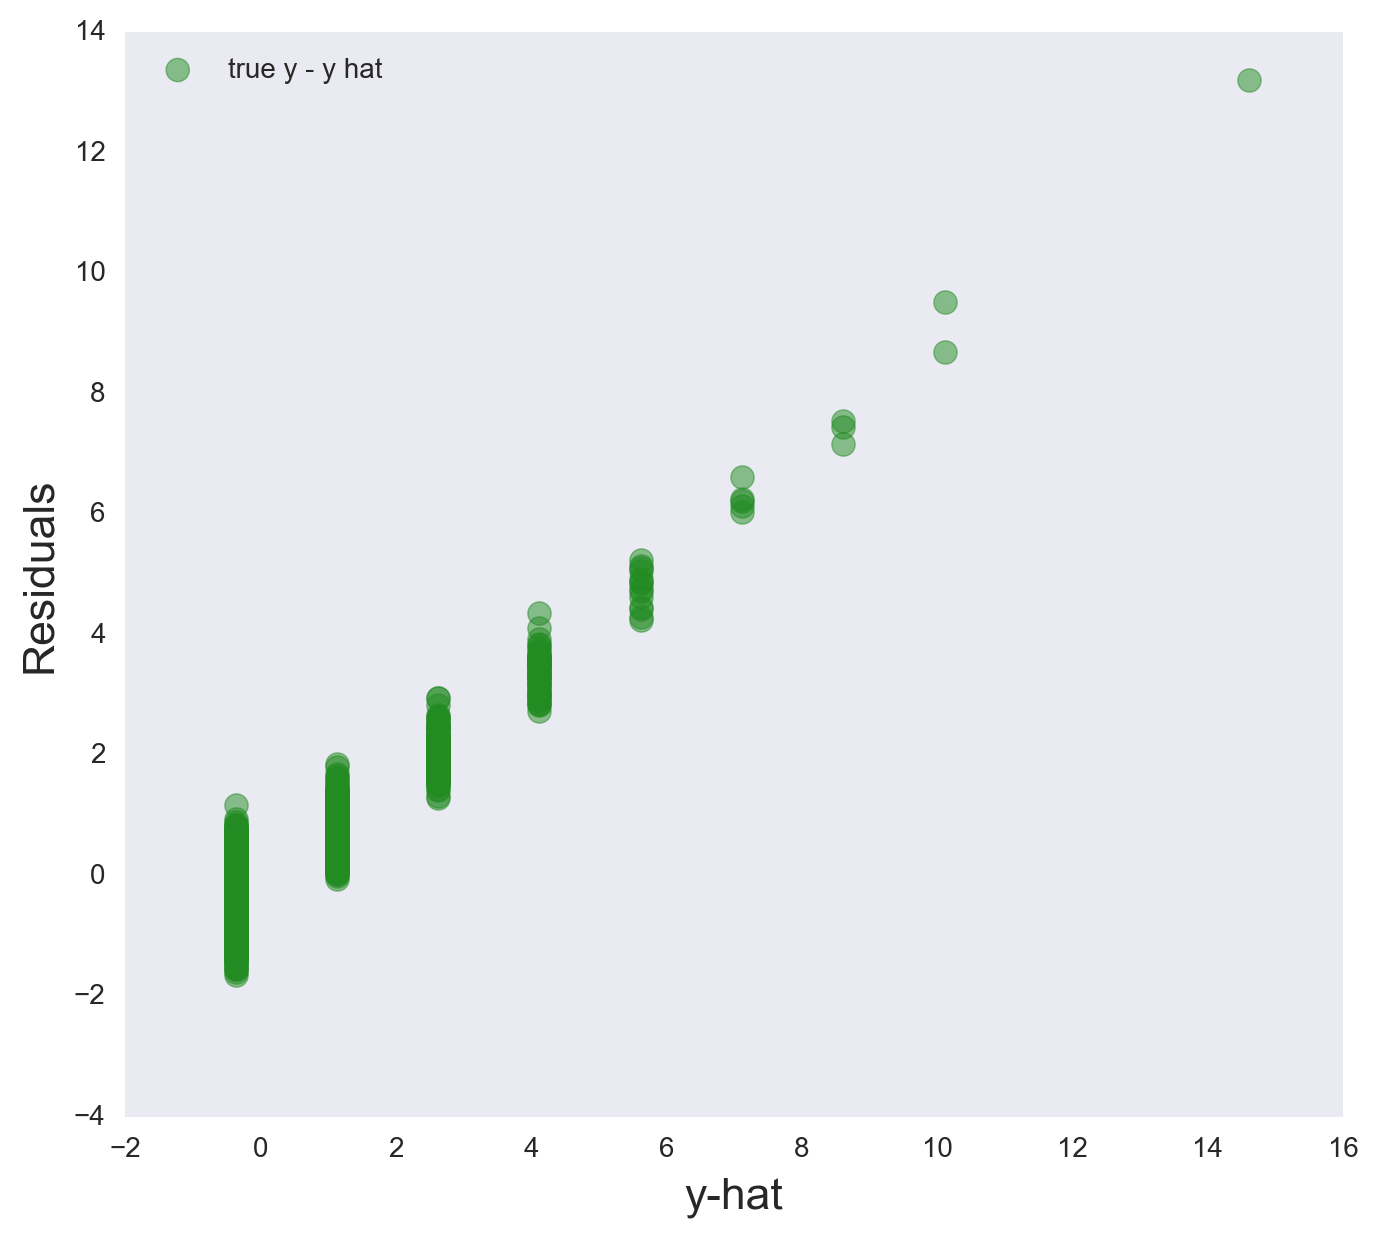

In [65]:
residuals = y - predictions

fig = plt.figure(figsize=(7,7))
ax = fig.gca()

ax.scatter(y, residuals, color='forestgreen', s=70, label='true y - y hat', alpha=.50)

max_x = np.max(y)+10

ax.set_xlabel('y-hat', fontsize=16)
ax.set_ylabel('Residuals', fontsize=16)

plt.legend(loc='upper left')

plt.show()

In [123]:
import folium
from folium.utilities import split_six
import pandas as pd

NYC_geo = r'../Capstone/boroughs.geojson'
NYC_collisions = r'../../datasets/NY_merged_samp.pkl'

NYC_data = pd.read_pickle(NYC_collisions)

#Let Folium determine the scale
map = folium.Map(location=[40.6347476, -74.1122528], zoom_start=5)
map.choropleth(geo_path=NYC_geo, data=NYC_data,
             columns=['BOROUGH', 'NUMBER_OF_CYCLIST_INJURED'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Number of cycling accidents')
map.create_map(path='map_1.html')

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.
/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Map.create_map is deprecated. Use Map.save instead


KeyError: 1